In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import os
from astropy.modeling import models
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.special import voigt_profile
import Analysis_functions as AF
from importlib import reload
from scipy.interpolate import interp1d

## Get the spectra for a given day

In [69]:
#Defining the directory names used to extract the data.
location = '/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/Solar-data/2023-01-24'
os.chdir(location)
dir_name = 'Corr-data'
blaze_dir = 'Blaze-data'
CCF_dir_name = 'CCF_RV-data'

#Creating a directory to store the results.
if not os.path.exists('Plot_Results'):
    os.mkdir('Plot_Results')

## Extract data

In [70]:
reload(AF)

#Extracting the data
tot_lamda, tot_spctr, tot_norm_spctr, tot_err, tot_norm_err, tot_SNR, tot_mode, tot_date, tot_RV, tot_RV_err, tot_FWHM, tot_FWHM_err, tot_BIS_SPAN, tot_BIS_SPAN_err, tot_H2O, tot_H2O_err, tot_O2, tot_O2_err, tot_CO2, tot_CO2_err, tot_AIRM = AF.extraction(dir_name, blaze_dir, CCF_dir_name, 14)



In [72]:
sorted(tot_AIRM)

[1.01575604340521,
 1.015760974700385,
 1.0157678412280648,
 1.015782635440595,
 1.0157969762283798,
 1.015821796054445,
 1.01584251093144,
 1.015877196323545,
 1.015904781787335,
 1.01594933504607,
 1.015985228573295,
 1.016039814499225,
 1.0160812626486,
 1.016145723072245,
 1.0161940519720551,
 1.01626839117114,
 1.016325869090735,
 1.0164102540725701,
 1.016472472320445,
 1.0165667467014652,
 1.01663586198747,
 1.016740032029145,
 1.016819145066115,
 1.0169333800883051,
 1.017016423762255,
 1.0171405690779198,
 1.017230532233065,
 1.017364596097115,
 1.0174614875394599,
 1.01760547887032,
 1.01771351133557,
 1.017867602702775,
 1.017978493861135,
 1.0182603828562198,
 1.0185642406360351,
 1.01888028952909,
 1.0192133168833801,
 1.01956922937656,
 1.01993657434797,
 1.02032098225623,
 1.020729208468635,
 1.02114811703022,
 1.021584185636585,
 1.0220374492979651,
 1.0225158012405,
 1.02300384913185,
 1.0235092062761248,
 1.023771723737805,
 1.0240406271539149,
 1.0243031896970751,
 1

## Remove outliers and low-SNR spectra

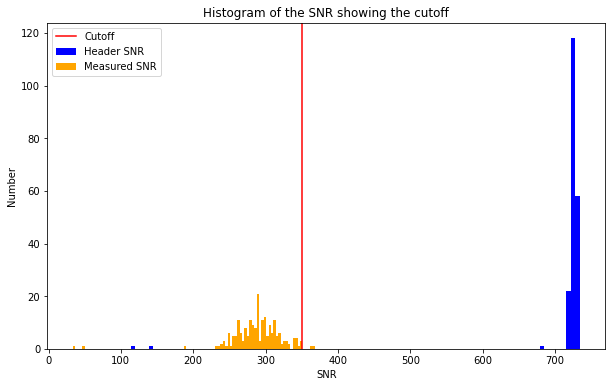

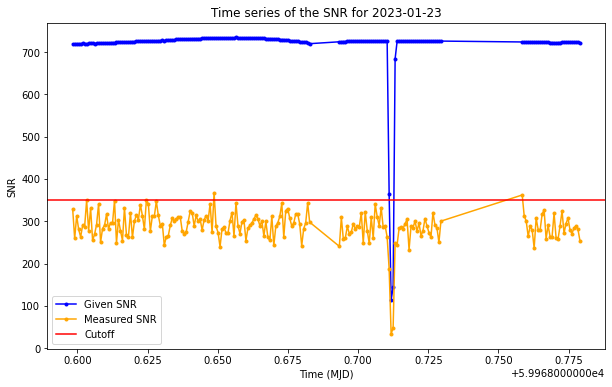

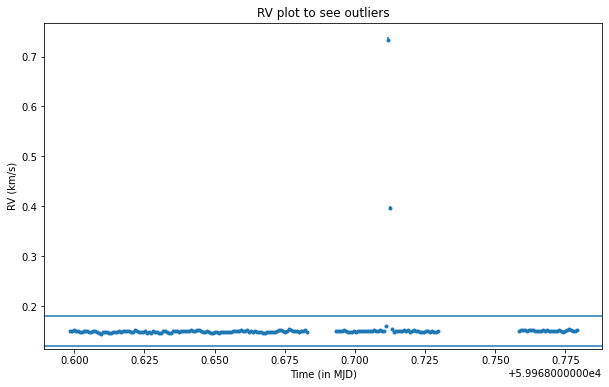

In [71]:
reload(AF)
#Defining a variable to save or not the results.
save = False
#Defining the thresholds and cuts for the RV and SNR clipping.
cut = 350
threshold = 0.2

#Defining the bounds on the piece of continuum we want to use to calculate the SNR.
low = 10767
up = 10770

#Calculating the continuum for a piece of spectral continuum.
measured_SNR = AF.SNR_calculator(low, up, tot_lamda, tot_spctr, tot_err)

#Making a histogram of the calculated SNR and the given SNR.
plt.figure(figsize=[10, 6])
plt.hist(tot_SNR, bins=100, color='blue', label='Header SNR')
plt.hist(measured_SNR, bins=100, color='orange', label='Measured SNR')
plt.axvline(cut, color='r', label='Cutoff')
plt.xlabel('SNR')
plt.ylabel('Number')
plt.title('Histogram of the SNR showing the cutoff')
plt.legend()
plt.show()

#Making a time series of the calculated SNR and the given SNR.
plt.figure(figsize=[10, 6])
plt.plot(tot_date[tot_SNR>0], tot_SNR[tot_SNR>0], 'b.', label='Given SNR', linestyle='-')
plt.plot(tot_date, measured_SNR, '.', color='orange', label='Measured SNR', linestyle='-')
plt.xlabel('Time (MJD)')
plt.ylabel('SNR')
plt.axhline(cut, color='r', label='Cutoff')
plt.title('Time series of the SNR for 2023-01-23')
plt.legend()
if save:
    plt.savefig('Plot_Results/SNR.pdf')
plt.show()

#Plotting the RV time series to see the cut and the possible outliers.
plt.figure(figsize=[10, 6])
plt.errorbar(tot_date, np.abs(tot_RV), yerr = np.abs(tot_RV_err), fmt='.')
plt.axhline((1+threshold)*np.median(np.abs(tot_RV)))
plt.axhline((1-threshold)*np.median(np.abs(tot_RV)))
plt.xlabel('Time (in MJD)')
plt.ylabel('RV (km/s)')
plt.title('RV plot to see outliers')
plt.show()


In [41]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):
    
    #Performing the data reduction by SNR and RV clipping.
    
    total_spctr_HA, total_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, cut, tot_AIRM)

    tota_norm_spctr_HA, tota_norm_spctr_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, cut, tot_AIRM)

    total_lamda_HA, total_lamda_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, cut, tot_AIRM)
    
    total_err_HA, total_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, cut, tot_AIRM)

    tota_norm_err_HA, tota_norm_err_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, cut, tot_AIRM)
    
    date_HA, date_HE = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, cut, tot_AIRM)


#If there is one mode of observation
else:
    
    #Performing the data reduction by SNR and RV clipping.
    
    total_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_spctr, tot_RV, cut, tot_AIRM)

    tota_norm_spctr = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_spctr, tot_RV, cut, tot_AIRM)

    total_lamda = AF.segment_and_reduce(tot_mode, tot_SNR, tot_lamda, tot_RV, cut, tot_AIRM)
    
    total_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_err, tot_RV, cut, tot_AIRM)

    tota_norm_err = AF.segment_and_reduce(tot_mode, tot_SNR, tot_norm_err, tot_RV, cut, tot_AIRM)
    
    date = AF.segment_and_reduce(tot_mode, tot_SNR, tot_date, tot_RV, cut, tot_AIRM)

    
mode = tot_mode

[]
[]
[]
[]
[]
[]


## Interpolation for ease

In [43]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(tot_mode=='A') != len(tot_mode) and np.sum(tot_mode=='E')!= len(tot_mode):

    min_lamda = max(max(total_lamda_HA[:, 0]), max(total_lamda_HE[:, 0]))
    max_lamda = min(min(total_lamda_HA[:, -1]), min(total_lamda_HE[:, -1]))

    step = (np.mean(np.diff(total_lamda_HA))+np.mean(np.diff(total_lamda_HE)))/2
    
    ref_wave = np.linspace(min_lamda, max_lamda, len(total_lamda_HA[0]))
    
    total_norm_spctr_HA = np.zeros(tota_norm_spctr_HA.shape)
    total_norm_spctr_HE = np.zeros(tota_norm_spctr_HE.shape)
    
    total_norm_err_HA = np.zeros(tota_norm_err_HA.shape)
    total_norm_err_HE = np.zeros(tota_norm_err_HE.shape)
    
    for i in range(len(tota_norm_spctr_HA)):
        
        interpol_s = interp1d(total_lamda_HA[i], tota_norm_spctr_HA[i])
        total_norm_spctr_HA[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda_HA[i], tota_norm_err_HA[i])
        total_norm_err_HA[i] = interpol_err(ref_wave)
        
    for i in range(len(tota_norm_spctr_HE)):
        
        interpol_s = interp1d(total_lamda_HE[i], tota_norm_spctr_HE[i])
        total_norm_spctr_HE[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda_HE[i], tota_norm_err_HE[i])
        total_norm_err_HE[i] = interpol_err(ref_wave)
        
else:
    
    min_lamda = max(total_lamda[:, 0])
    max_lamda = min(total_lamda[:, -1])

    step = np.mean(np.diff(total_lamda))
    
    ref_wave = np.linspace(min_lamda, max_lamda, len(total_lamda[0]))
    
    total_norm_spctr = np.zeros(tota_norm_spctr.shape)

    total_norm_err = np.zeros(tota_norm_err.shape)
        
    for i in range(len(tota_norm_spctr)):
        
        interpol_s = interp1d(total_lamda[i], tota_norm_spctr[i])
        total_norm_spctr[i] = interpol_s(ref_wave)
        
        
        interpol_err = interp1d(total_lamda[i], tota_norm_err[i])
        total_norm_err[i] = interpol_err(ref_wave)

In [44]:
###################################################################################
################# ADAPTED FROM WILLIAM DETHIER'S CODE #############################
###################################################################################

In [45]:
os.chdir('/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet')
import spectrum_model as spec_mod

In [46]:
##Defining the parameters for the planetary abosprtion simulation

# Helium density
density = 1.15e15

# Helium temperature -- thermal broadening
temperature = 10000

# Stellar rotation velocity -- non-thermal broadening
vsini = 2

# Reference medium for the wavelengths
medium= "VACUUM"

# Instrumental resolving power e.g. R_pow = 70000
# For non thermal broadening
# see spectrum_he() in spectrum_model.py to know where to write the argument

if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    R_power_HE = 74000
    R_power_HA = 86000
else:
    if mode[0] == 'A':
        R_power = 86000
    else:
        R_power = 74000
# Microturbulence
# for non thermal broadening
# micro_t = 1

# You can change the damping to have Voigt profiles, by default you have Gaussian profiles
# Set to value greater than 0
# d_damping = 0

## Simulating on one spectrum to see what it looks like

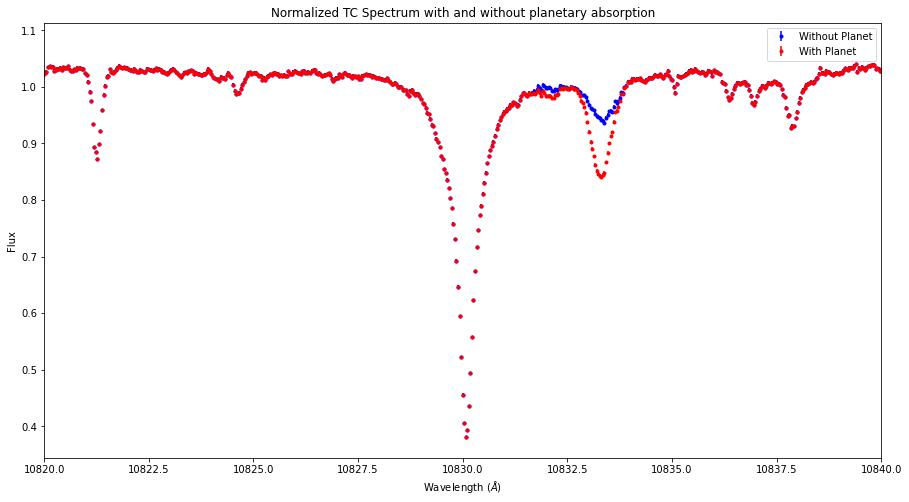

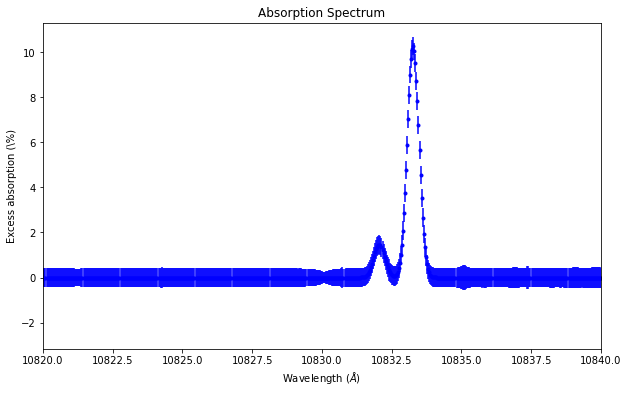

In [50]:
reload(AF)

#Random index of the spectrum to plot.
idx = 10

#Defining a variable to save or not the results.
save = False

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Making a theoretical spectra with a planetary absorption signal to see what it looks like.
    
    theoretical_spctr = spec_mod.spectrum_he(ref_wave, total_norm_spctr_HE[idx], temperature, density, vsini, medium, R_pow = R_power_HE)
    theoretical_err = spec_mod.spectrum_he(ref_wave, total_norm_err_HE[idx], temperature, density, vsini, medium, R_pow = R_power_HE)

    #Plotting the current spectra with and without a planetary signal.
    plt.figure(figsize=[15, 8])
    plt.errorbar(ref_wave, total_norm_spctr_HE[idx], yerr = total_norm_err_HE[idx], fmt='b.', label='Without Planet')
    plt.errorbar(ref_wave, theoretical_spctr, yerr = theoretical_err, fmt='r.', label='With Planet')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim([10820, 10840])
    plt.legend()
    plt.title('Normalized TC Spectrum with and without planetary absorption for HE')
    if save:
        plt.savefig('/Users/samsonmercier/Desktop/Planet.pdf')
    plt.show()
    
    #Plotting the absorption spectrum of the fake planet.
    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, (total_norm_spctr_HE[idx]-theoretical_spctr)*100, yerr = np.sqrt(total_norm_err_HE[idx]**2+theoretical_err**2)*100, fmt='b.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.title('Absorption Spectrum')
    plt.ylabel('Excess absorption (%)')
    plt.xlim([10820, 10840])
    plt.show()

#If there is one mode of observation
else:
    
    #Making a theoretical spectra with a planetary absorption signal to see what it looks like.

    theoretical_spctr = spec_mod.spectrum_he(ref_wave, total_norm_spctr[idx], temperature, density, vsini, medium, R_pow = R_power)
    theoretical_err = spec_mod.spectrum_he(ref_wave, total_norm_err[idx], temperature, density, vsini, medium, R_pow = R_power)

    #Plotting the current spectra with and without a planetary signal.
    plt.figure(figsize=[15, 8])
    plt.errorbar(ref_wave, total_norm_spctr[idx], yerr = total_norm_err[idx], fmt='b.', label='Without Planet')
    plt.errorbar(ref_wave, theoretical_spctr, yerr = total_norm_err[idx], fmt='r.', label='With Planet')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.xlim([10820, 10840])
    plt.legend()
    plt.title('Normalized TC Spectrum with and without planetary absorption')
    if save:
        plt.savefig('/Users/samsonmercier/Desktop/Planet.pdf')
    plt.show()
    
    #Plotting the absorption spectrum of the fake planet.
    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, (total_norm_spctr[idx]-theoretical_spctr)*100, yerr = np.sqrt(total_norm_err[idx]**2+theoretical_err**2)*100, fmt='b.')
    plt.xlabel('Wavelength ($\AA$)')
    plt.title('Absorption Spectrum')
    plt.ylabel('Excess absorption (\%)')
    plt.xlim([10820, 10840])
    plt.show()




## Defining in-transit and out-of-transit parts of the timeseries

In [52]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):    
    
    #Defining the bounds of transit
    low_bound_HA = int(len(date_HA)/4)
    up_bound_HA = int(3*len(date_HA)/4)
    
    low_bound_HE = int(len(date_HE)/4)
    up_bound_HE = int(3*len(date_HE)/4)


    #Making the spectra
    #Before transit
    out_transit_spctr_HA_1 = AF.bound(date_HA[0], date_HA[low_bound_HA], date_HA, total_norm_spctr_HA)
    out_transit_err_HA_1 = AF.bound(date_HA[0], date_HA[low_bound_HA], date_HA, total_norm_err_HA)
    #In transit
    in_transit_spctr_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, total_norm_spctr_HA)
    in_transit_err_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, total_norm_err_HA)
    #After transit
    out_transit_spctr_HA_2 = AF.bound(date_HA[up_bound_HA], date_HA[-1], date_HA, total_norm_spctr_HA)
    out_transit_err_HA_2 = AF.bound(date_HA[up_bound_HA], date_HA[-1], date_HA, total_norm_err_HA)
    #Out-of-transit
    out_transit_spctr_HA = np.concatenate((out_transit_spctr_HA_1, out_transit_spctr_HA_2)) 
    out_transit_err_HA = np.concatenate((out_transit_err_HA_1, out_transit_err_HA_2)) 

    #Before transit
    out_transit_spctr_HE_1 = AF.bound(date_HE[0], date_HE[low_bound_HE], date_HE, total_norm_spctr_HE)
    out_transit_err_HE_1 = AF.bound(date_HE[0], date_HE[low_bound_HE], date_HE, total_norm_err_HE)
    #In transit
    in_transit_spctr_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, total_norm_spctr_HE)
    in_transit_err_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, total_norm_err_HE)
    #After transit
    out_transit_spctr_HE_2 = AF.bound(date_HE[up_bound_HE], date_HE[-1], date_HE, total_norm_spctr_HE)
    out_transit_err_HE_2 = AF.bound(date_HE[up_bound_HE], date_HE[-1], date_HE, total_norm_err_HE)
    #Out-of-transit
    out_transit_spctr_HE = np.concatenate((out_transit_spctr_HE_1, out_transit_spctr_HE_2)) 
    out_transit_err_HE = np.concatenate((out_transit_err_HE_1, out_transit_err_HE_2)) 
  
    #Making the timestamps in transit -- for plotting purposes later
    date_in_transit_HA = AF.bound(date_HA[low_bound_HA], date_HA[up_bound_HA], date_HA, date_HA)
    date_in_transit_HE = AF.bound(date_HE[low_bound_HE], date_HE[up_bound_HE], date_HE, date_HE)

#If there is one mode of observation
else:    
    #Defining the bounds of transit
    low_bound = int(len(date)/4)
    up_bound = int(3*len(date)/4)
 
    #Making the spectra
    #Before transit
    out_transit_spctr_1 = AF.bound(date[0], date[low_bound], date, total_norm_spctr)
    out_transit_err_1 = AF.bound(date[0], date[low_bound], date, total_norm_err)
    #In transitc
    in_transit_spctr = AF.bound(date[low_bound], date[up_bound], date, total_norm_spctr)
    in_transit_err = AF.bound(date[low_bound], date[up_bound], date, total_norm_err)
    #After transit
    out_transit_spctr_2 = AF.bound(date[up_bound], date[-1], date, total_norm_spctr)
    out_transit_err_2 = AF.bound(date[up_bound], date[-1], date, total_norm_err)
    #Out-of-transit
    out_transit_spctr = np.concatenate((out_transit_spctr_1, out_transit_spctr_2)) 
    out_transit_err = np.concatenate((out_transit_err_1, out_transit_err_2)) 

    #Making the timestamps in transit -- for plotting purposes later
    date_in_transit = AF.bound(date[low_bound], date[up_bound], date, date)


## Adding the planetary signal during the transit

In [53]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    #Initiating arrays to contain the in-transit spectra with a planetary signal and their corresponding errors.
    planet_in_transit_spctr_HA = np.ones(in_transit_spctr_HA.shape)
    planet_in_transit_err_HA = np.ones(in_transit_err_HA.shape)
    
    planet_in_transit_spctr_HE = np.ones(in_transit_spctr_HE.shape)
    planet_in_transit_err_HE = np.ones(in_transit_err_HE.shape)
    
    #Populating the above defined arrays.
    for i in range(len(in_transit_spctr_HA)):

        planet_in_transit_spctr_HA[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr_HA[i], temperature, density, vsini, medium, R_pow = R_power_HA)
        planet_in_transit_err_HA[i] = spec_mod.spectrum_he(ref_wave, in_transit_err_HA[i], temperature, density, vsini, medium, R_pow = R_power_HA)
    
    for i in range(len(in_transit_spctr_HE)):

        planet_in_transit_spctr_HE[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr_HE[i], temperature, density, vsini, medium, R_pow = R_power_HE)
        planet_in_transit_err_HE[i] = spec_mod.spectrum_he(ref_wave, in_transit_err_HE[i], temperature, density, vsini, medium, R_pow = R_power_HE)

#If there is one mode of observation    
else:
    #Initiating arrays to contain the in-transit spectra with a planetary signal and their corresponding errors.
    planet_in_transit_spctr = np.ones(in_transit_spctr.shape)
    planet_in_transit_err = np.ones(in_transit_err.shape)
    
    #Populating the above defined arrays.
    for i in range(len(in_transit_spctr)):

        planet_in_transit_spctr[i] = spec_mod.spectrum_he(ref_wave, in_transit_spctr[i], temperature, density, vsini, medium, R_pow = R_power)
        planet_in_transit_err[i] = spec_mod.spectrum_he(ref_wave, in_transit_err[i], temperature, density, vsini, medium, R_pow = R_power)



## Getting the master spectrum in and out of transit

In [54]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    #Making the master spectra, in and out of transit.
    
    #In-transit
    master_planet_intransit_HA = np.average(planet_in_transit_spctr_HA, axis=0, weights = 1/planet_in_transit_err_HA**2)
    master_err_intransit_HA = 1/np.sqrt(np.sum(1/planet_in_transit_err_HA**2, axis=0))
    
    master_planet_intransit_HE = np.average(planet_in_transit_spctr_HE, axis=0, weights = 1/planet_in_transit_err_HE**2)
    master_err_intransit_HE = 1/np.sqrt(np.sum(1/planet_in_transit_err_HE**2, axis=0))

    #Out-of-transit
    master_outtransit_HA = np.average(out_transit_spctr_HA, axis=0, weights = 1/out_transit_err_HA**2)
    master_err_outtransit_HA = 1/np.sqrt(np.sum(1/out_transit_err_HA**2, axis=0))
    
    master_outtransit_HE = np.average(out_transit_spctr_HE, axis=0, weights = 1/out_transit_err_HE**2)
    master_err_outtransit_HE = 1/np.sqrt(np.sum(1/out_transit_err_HE**2, axis=0))
    
#If there is one mode of observation
else:
    #Making the master spectra, in and out of transit.
    
    #In-transit
    master_planet_intransit = np.average(planet_in_transit_spctr, axis=0, weights = 1/planet_in_transit_err**2)
    master_err_intransit = 1/np.sqrt(np.sum(1/planet_in_transit_err**2, axis=0))

    #Out-of-transit
    master_outtransit = np.average(out_transit_spctr, axis=0, weights = 1/out_transit_err**2)
    master_err_outtransit = 1/np.sqrt(np.sum(1/out_transit_err**2, axis=0))
    

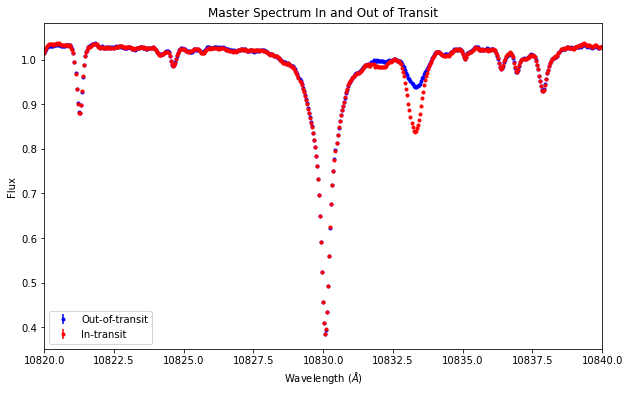

In [55]:
reload(AF)
#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Plotting the master spectra 

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit_HA, yerr = master_err_outtransit_HA, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit_HA, yerr = master_err_intransit_HA, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit for HA')
    plt.xlim([10820, 10840])
    plt.show()

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit_HE, yerr = master_err_outtransit_HE, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit_HE, yerr = master_err_intransit_HE, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit for HE')
    plt.xlim([10820, 10840])
    plt.show()

#If there is one mode of observation
else:
    
    #Plotting the master spectra 

    plt.figure(figsize=[10, 6])
    plt.errorbar(ref_wave, master_outtransit, yerr = master_err_outtransit, fmt='b.', label='Out-of-transit')
    plt.errorbar(ref_wave, master_planet_intransit, yerr = master_err_intransit, fmt='r.', label='In-transit')
    plt.legend()
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Flux')
    plt.title('Master Spectrum In and Out of Transit')
    plt.xlim([10820, 10840])
    plt.show()


## Retrieving the planetary parameters once again

In [56]:
reload(AF)

##Defining the difference between the in-transit and master out-of-transit spectra to get 
#a time series of the planet's spectrum
offset = 1

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    
    #Initiating arrays to contain the values and error of the planetary absorption spectrum.
    diff_HA = np.ones(planet_in_transit_spctr_HA.shape)
    diff_HA_err = np.ones(planet_in_transit_err_HA.shape)
    
    #Populating the above defined arrays.
    #We add an offset of 1 for later fitting purposes.
    for i in range(len(planet_in_transit_spctr_HA)):
        diff_HA[i] = offset+(master_outtransit_HA - planet_in_transit_spctr_HA[i])/master_outtransit_HA
        diff_HA_err[i] = np.sqrt((planet_in_transit_err_HA[i]/master_outtransit_HA)**2 + ((planet_in_transit_spctr_HA[i] * master_err_outtransit_HA)/(master_outtransit_HA**2))**2)
        #diff_HA_err[i] = diff_HA[i] * np.sqrt((planet_in_transit_err_HA[i]/planet_in_transit_spctr_HA[i])**2 + (master_err_outtransit_HA/master_outtransit_HA)**2)
        #diff_HA_err[i] = np.sqrt(((master_outtransit_HA**2 * planet_in_transit_err_HA[i]**2)+(planet_in_transit_spctr_HA[i]**2 * master_err_outtransit_HA**2))/master_outtransit_HA**4)

    diff_HE = np.ones(planet_in_transit_spctr_HE.shape)
    diff_HE_err = np.ones(planet_in_transit_err_HE.shape)
    for i in range(len(planet_in_transit_spctr_HE)):
        diff_HE[i] = offset+(master_outtransit_HE - planet_in_transit_spctr_HE[i])/master_outtransit_HE
        diff_HE_err[i] = np.sqrt((planet_in_transit_err_HE[i]/master_outtransit_HE)**2 + ((planet_in_transit_spctr_HE[i] * master_err_outtransit_HE)/(master_outtransit_HE**2))**2)

#If there is one mode of observation
else:
    
    #Initiating arrays to contain the values and error of the planetary absorption spectrum.
    diff = np.ones(planet_in_transit_spctr.shape)
    diff_err = np.ones(planet_in_transit_err.shape)
    
    #Populating the above defined arrays.
    #We add an offset of 1 for later fitting purposes.
    for i in range(len(planet_in_transit_spctr)):
        diff[i] = offset+(master_outtransit - planet_in_transit_spctr[i])/master_outtransit
        diff_err[i] = np.sqrt((planet_in_transit_err[i]/master_outtransit)**2 + ((planet_in_transit_spctr[i] * master_err_outtransit)/(master_outtransit**2))**2)



/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01271683e+04 -1.06245109e+15  1.82309781e-04]


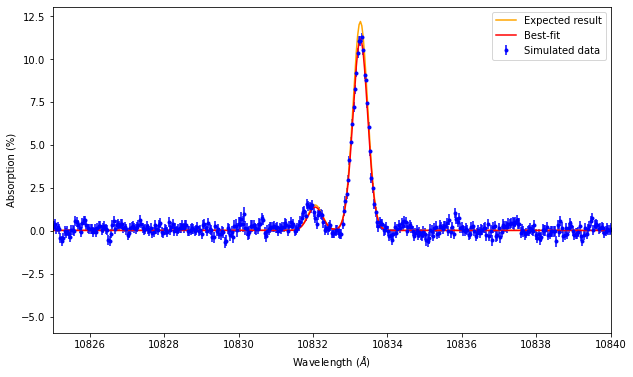

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01975876e+04 -1.04252978e+15  1.20236980e-04]


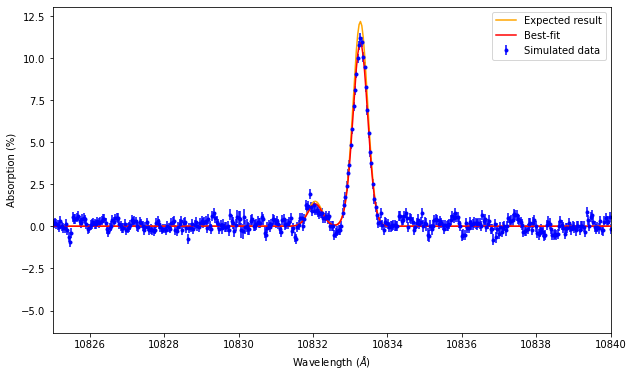

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06237541e+04 -1.06687839e+15  7.61101565e-05]


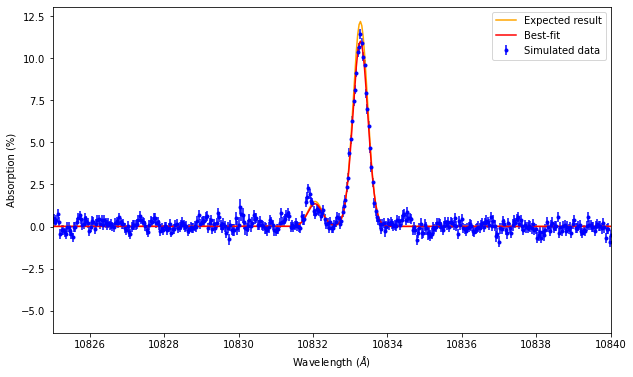

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10611164e+04 -1.06834660e+15  1.39014770e-04]


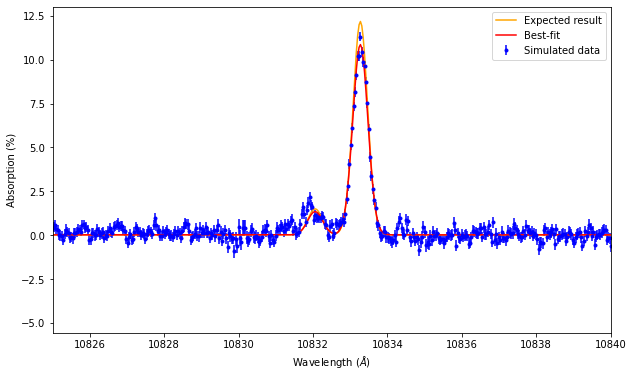

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08529339e+04 -1.06194927e+15  2.85112773e-04]


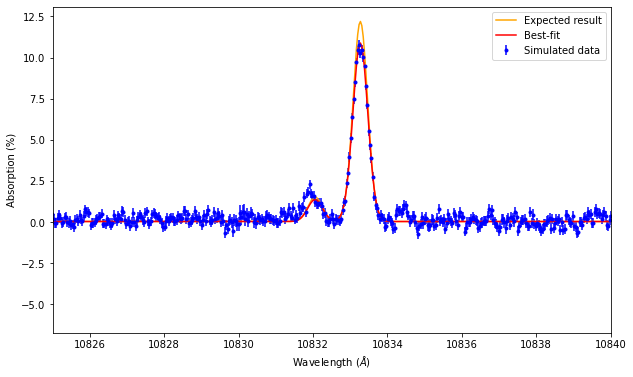

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03410258e+04 -1.05495896e+15 -1.79492971e-05]


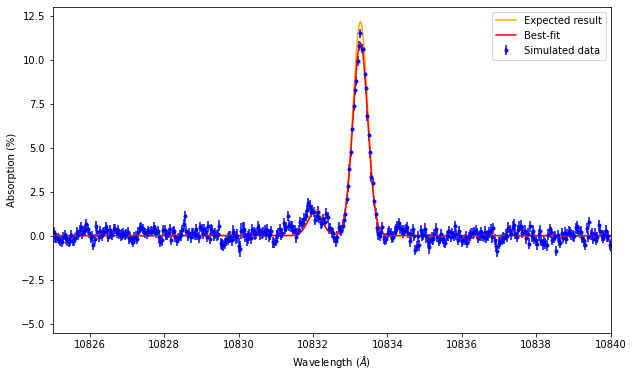

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12918848e+04 -1.07402351e+15  2.19775768e-04]


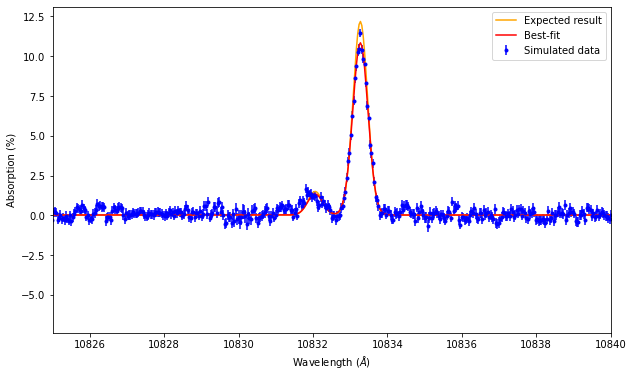

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.45750559e+03 -1.04528142e+15  1.21699828e-04]


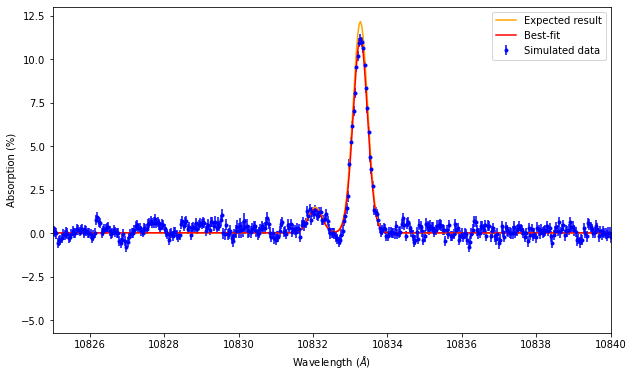

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05502926e+04 -1.04920076e+15  4.44392860e-04]


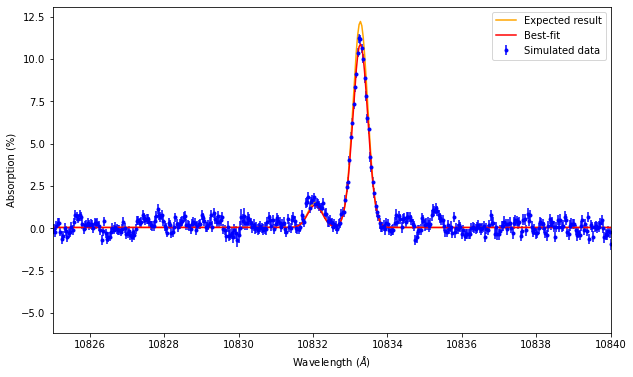

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.18183541e+04 -1.07643700e+15  4.38287628e-04]


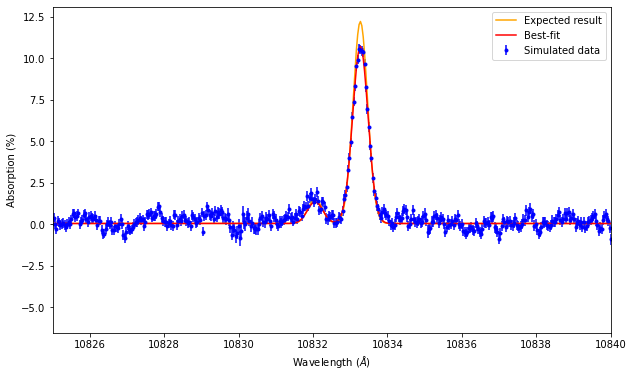

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02679295e+04 -1.05341847e+15  4.26394589e-05]


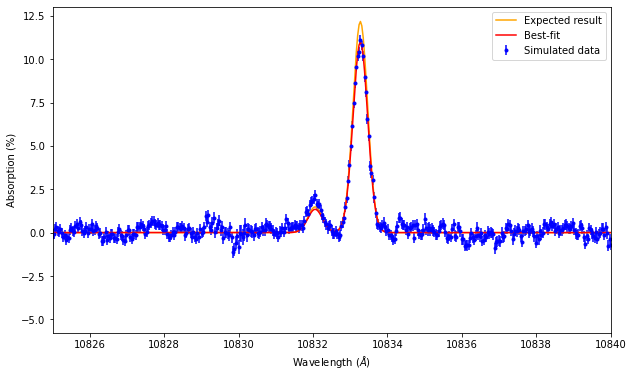

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08119347e+04 -1.07746912e+15  1.10868292e-04]


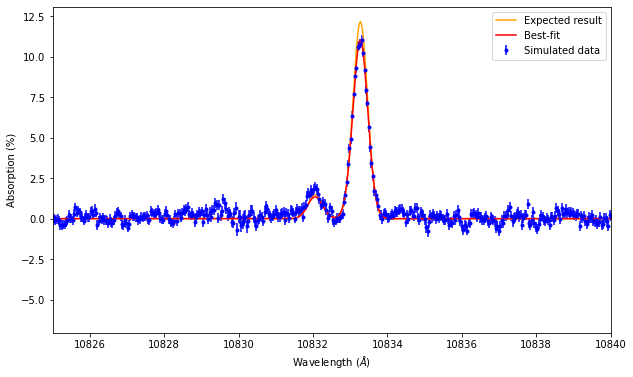

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04748836e+04 -1.03822182e+15 -1.35812902e-04]


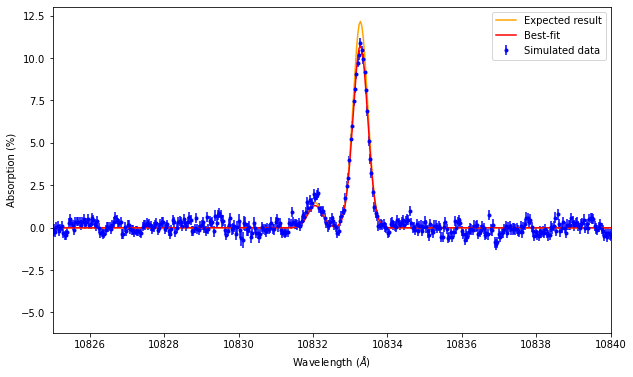

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06903858e+04 -1.06437532e+15  3.81289534e-04]


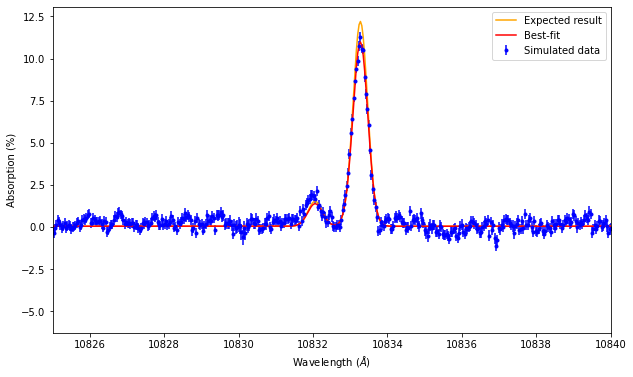

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09565236e+04 -1.05028752e+15  2.36036430e-04]


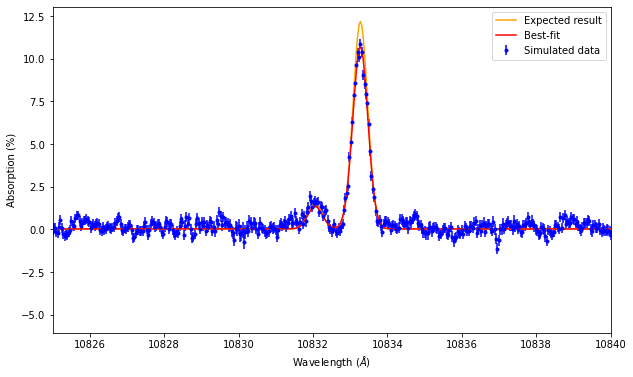

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07278631e+04 -1.03694898e+15  1.94285657e-04]


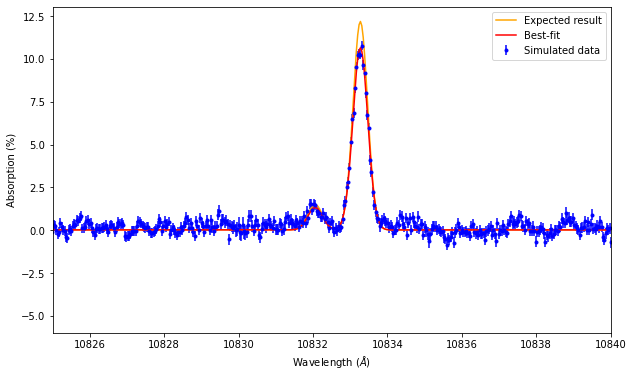

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06642824e+04 -1.05974005e+15  2.56030628e-04]


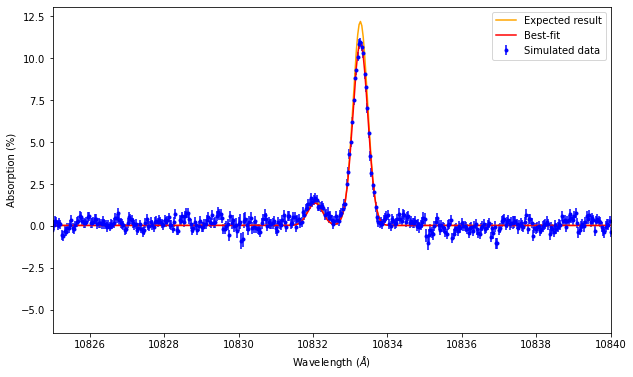

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.89101339e+03 -1.01876392e+15  1.33780507e-04]


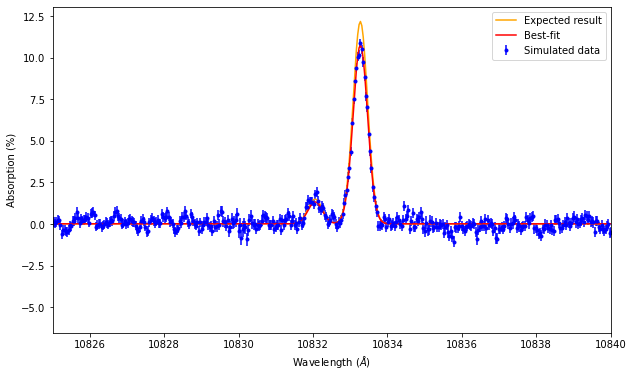

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03344010e+04 -1.05012752e+15 -7.44998287e-05]


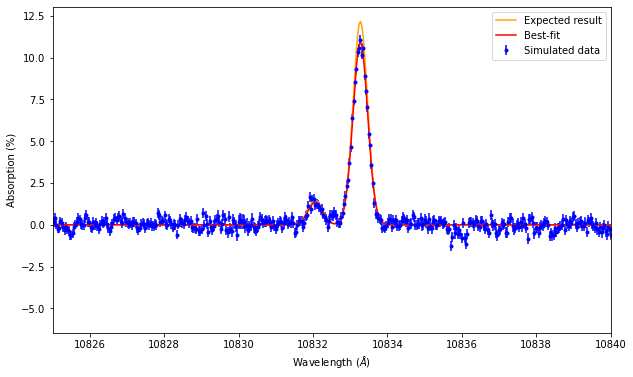

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03980143e+04 -1.03961933e+15  2.73935998e-04]


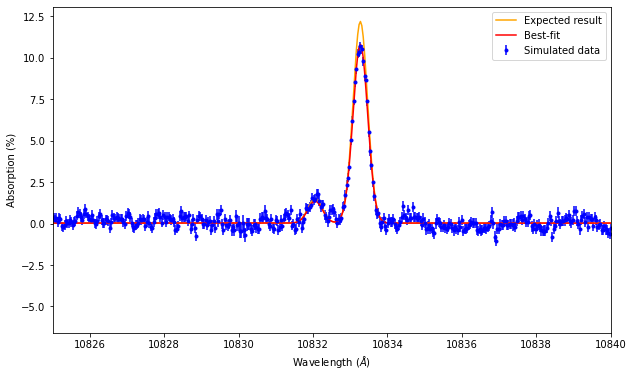

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07699158e+04 -1.03978624e+15 -1.45826952e-04]


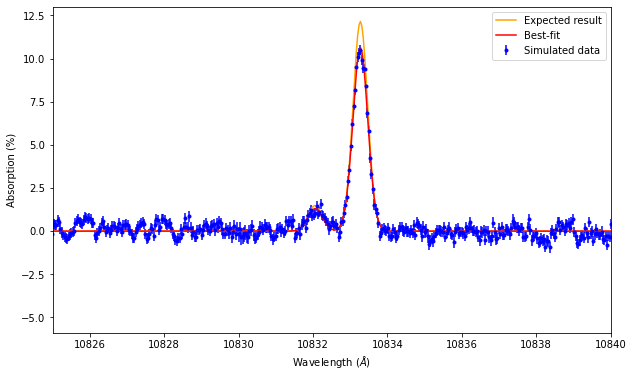

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.79893156e+03 -1.02650631e+15  1.09368426e-04]


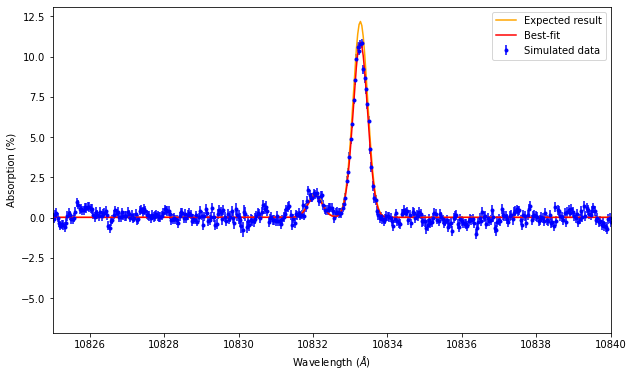

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00217417e+04 -1.05481329e+15 -1.63401646e-05]


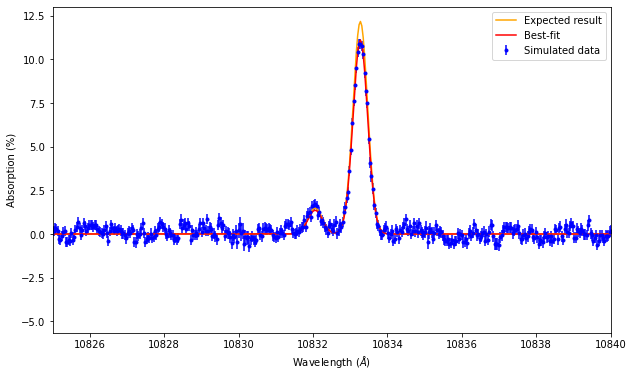

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04997750e+04 -1.06281807e+15  3.30736584e-04]


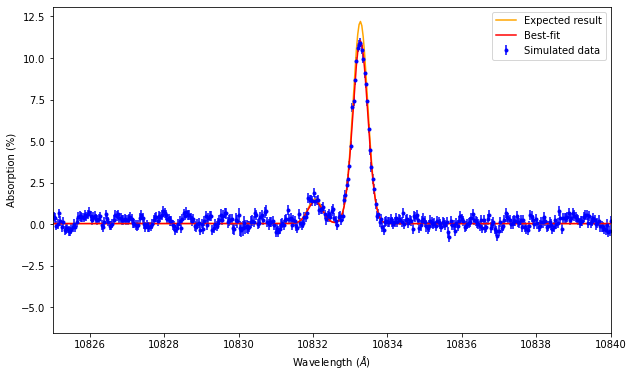

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04404113e+04 -1.07074990e+15 -6.05199794e-05]


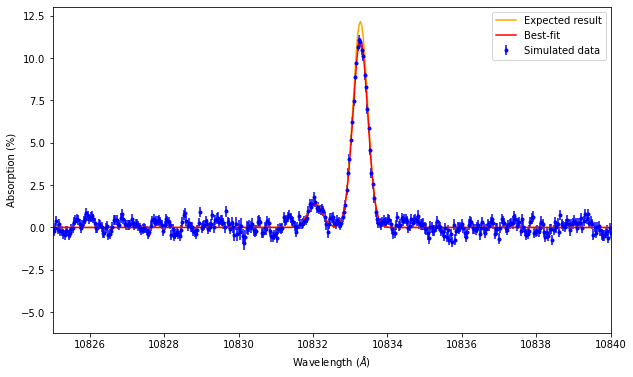

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09276290e+04 -1.06537806e+15  2.27168607e-04]


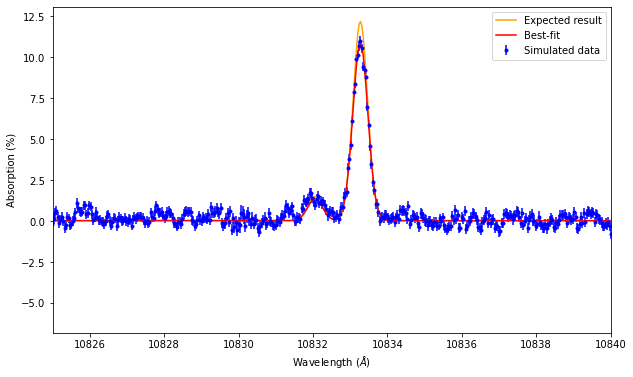

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08051312e+04 -1.06001556e+15  3.35328015e-04]


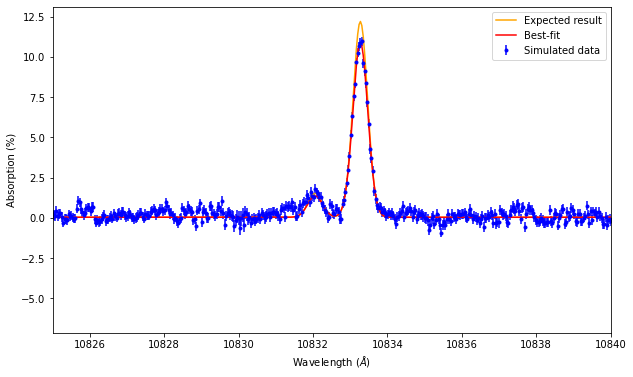

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06331092e+04 -1.04792999e+15  2.01292884e-04]


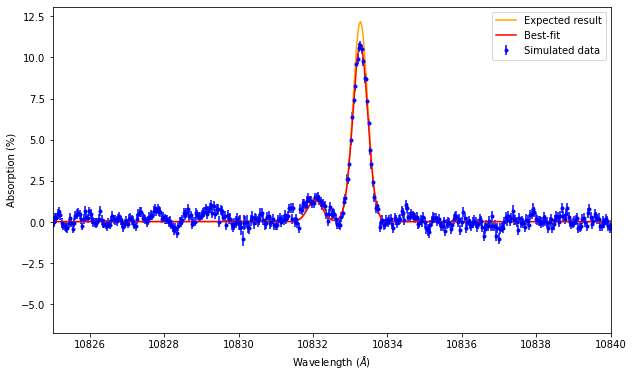

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05866686e+04 -1.01868061e+15  3.95673921e-04]


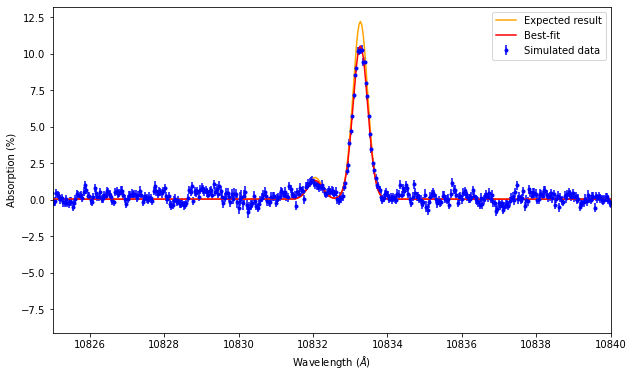

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.86467228e+03 -9.98696574e+14 -6.92689512e-05]


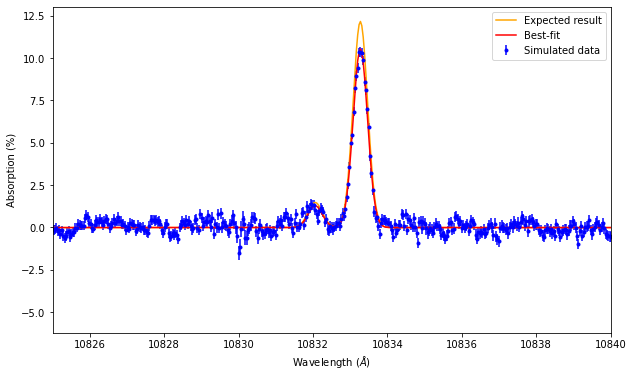

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06689566e+04 -1.04667630e+15  1.14656168e-04]


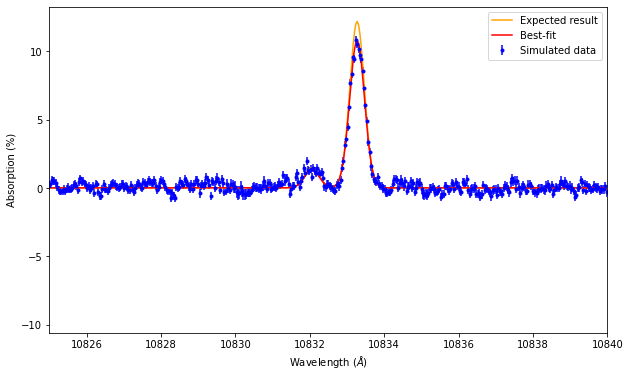

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08525670e+04 -1.03722987e+15 -2.90644364e-05]


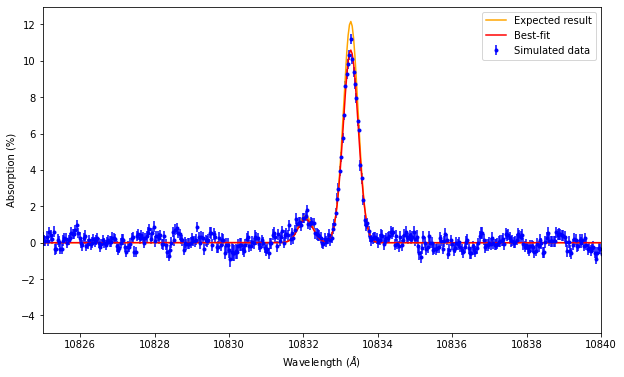

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03960055e+04 -1.02686165e+15  1.24798992e-04]


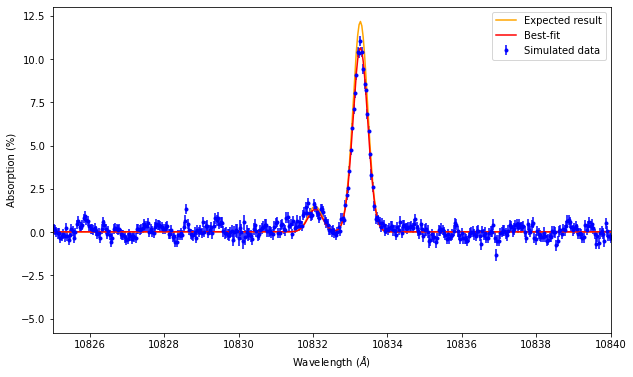

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10937582e+04 -1.06925020e+15  6.44665125e-05]


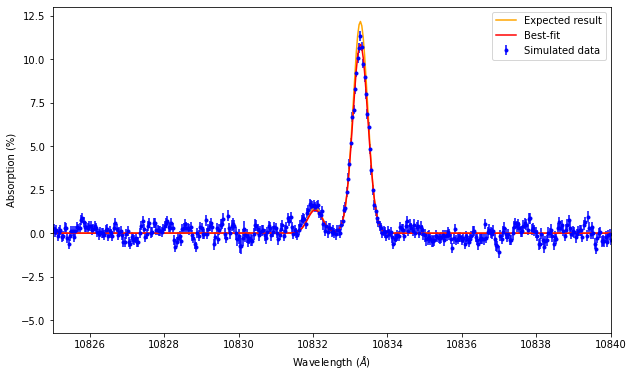

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10828252e+04 -1.05706626e+15  1.30460270e-04]


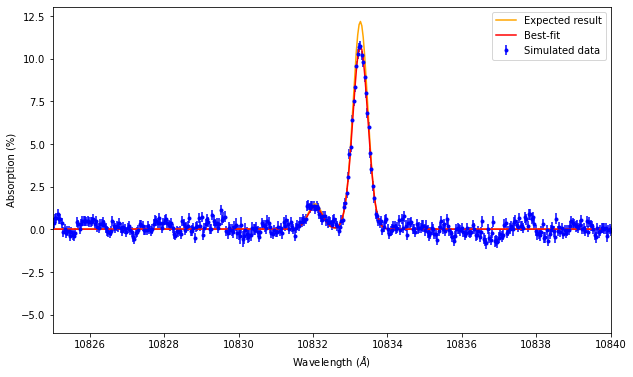

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09369267e+04 -1.03399900e+15  1.83467032e-04]


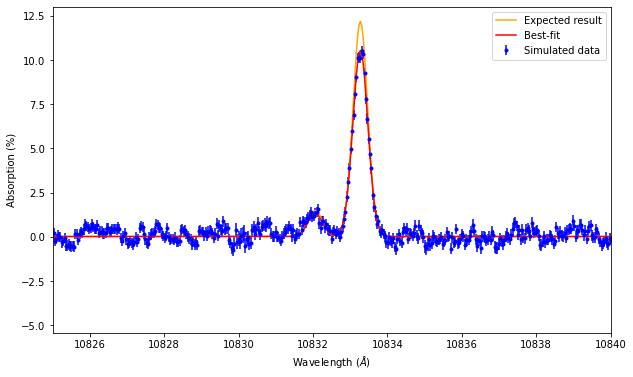

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05876813e+04 -1.03138577e+15  2.88116277e-05]


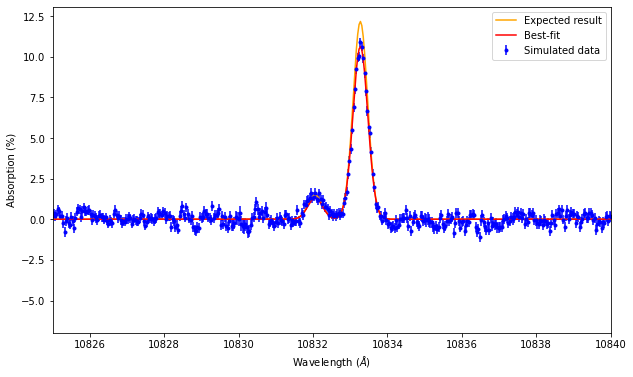

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02989798e+04 -1.00581415e+15  1.44385214e-04]


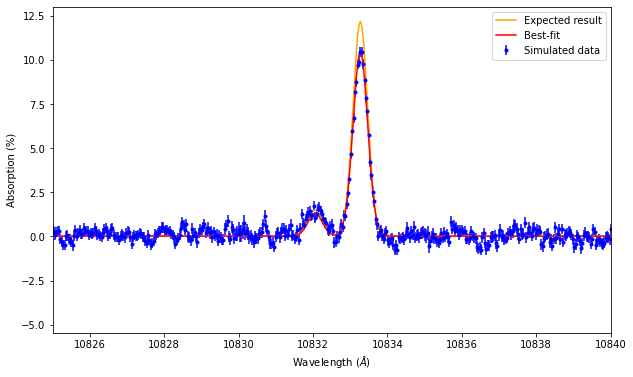

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.06427751e+03 -9.91199562e+14 -1.18409348e-04]


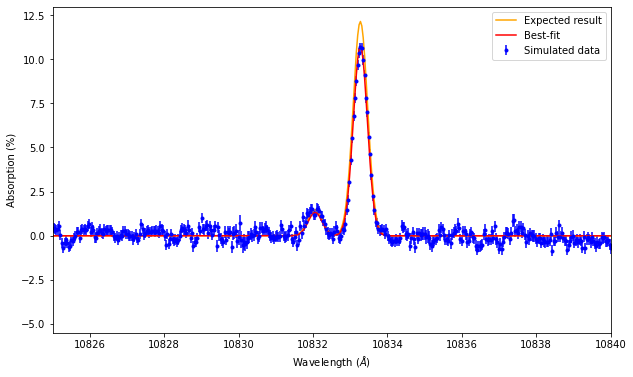

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07736038e+04 -1.04667962e+15 -9.30111718e-05]


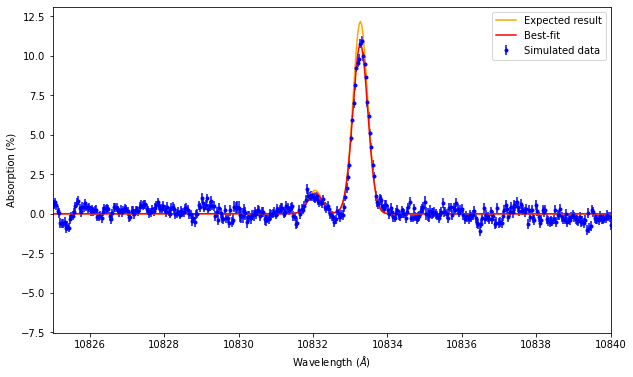

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06523514e+04 -1.03740753e+15 -2.93549432e-05]


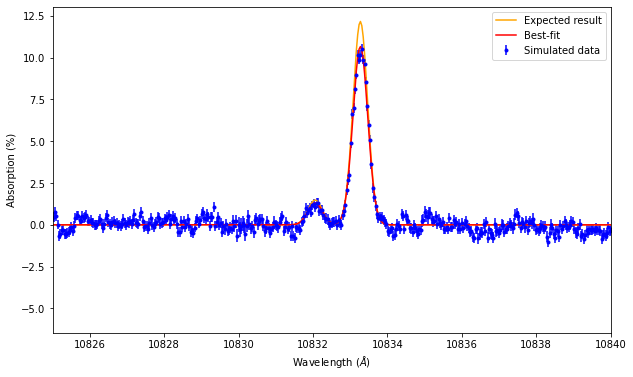

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07281837e+04 -1.04750214e+15 -4.86043106e-05]


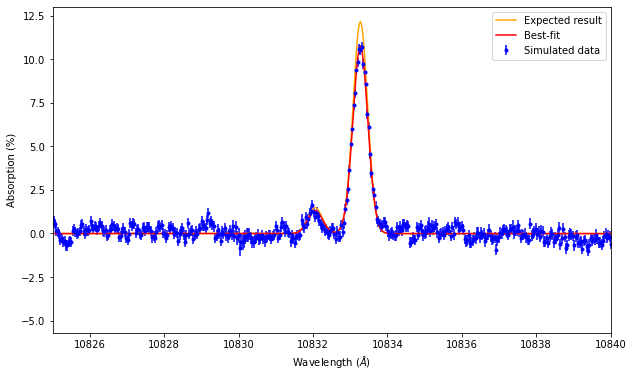

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04124943e+04 -1.05141911e+15  2.22408252e-04]


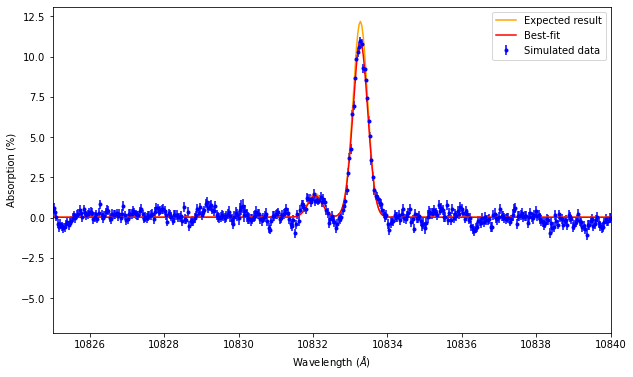

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07471484e+04 -1.05353946e+15  1.16594158e-04]


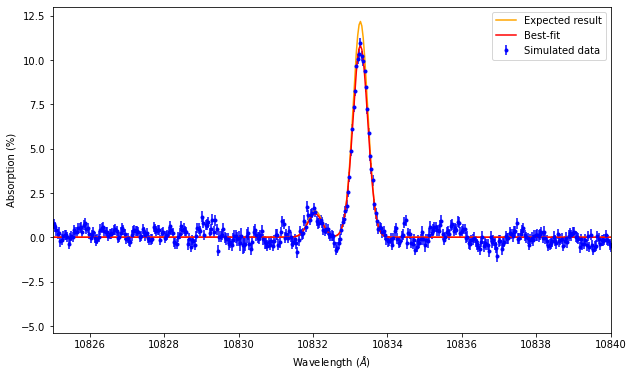

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07655416e+04 -1.05490523e+15  1.73835418e-04]


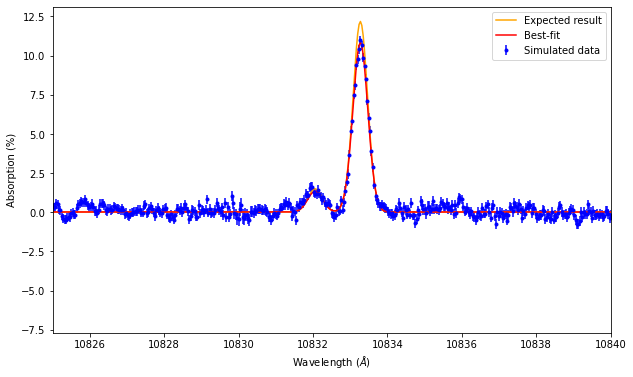

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09696243e+04 -1.06063592e+15 -3.42769846e-05]


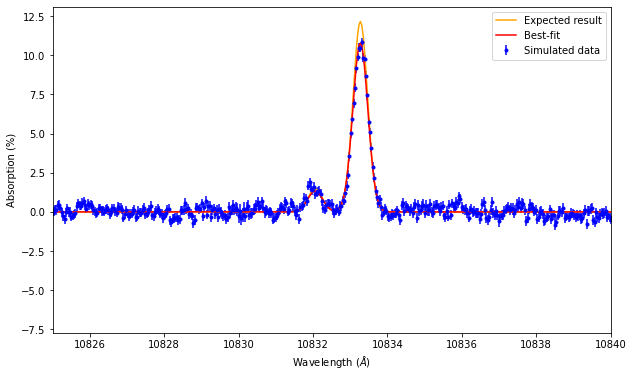

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10231395e+04 -1.06372316e+15  2.32073607e-04]


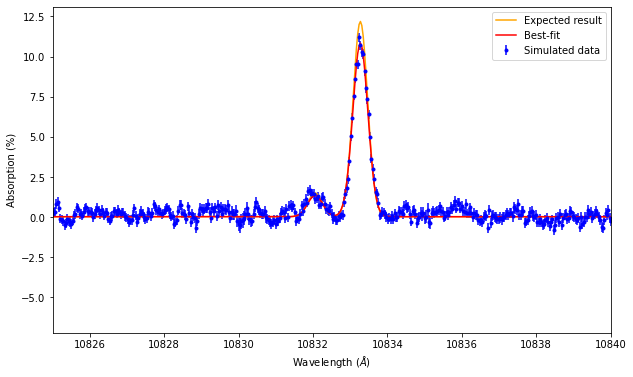

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09023298e+04 -1.07686205e+15 -1.30318434e-04]


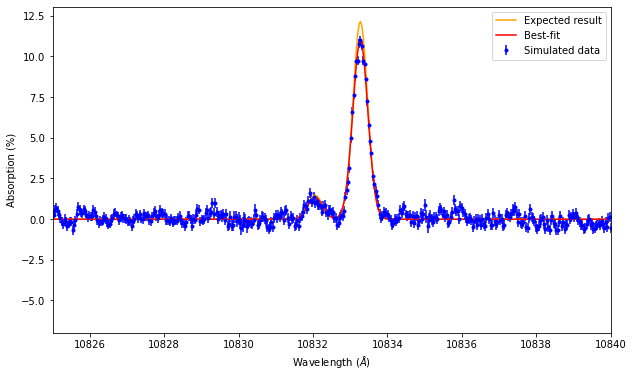

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09693022e+04 -1.05537979e+15  9.80668097e-06]


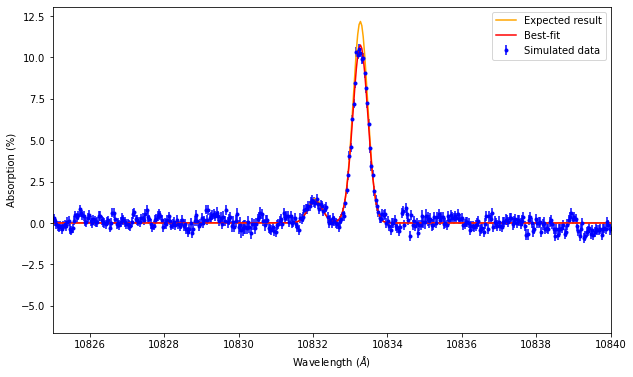

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06588733e+04 -1.05477782e+15 -4.28150794e-05]


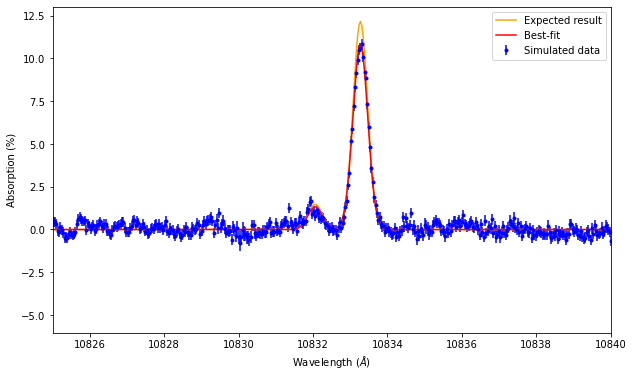

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11906998e+04 -1.06950655e+15  1.05442736e-04]


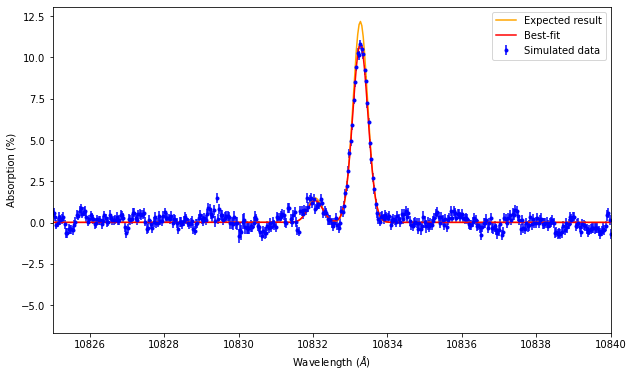

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10848907e+04 -1.07865626e+15  5.49195535e-05]


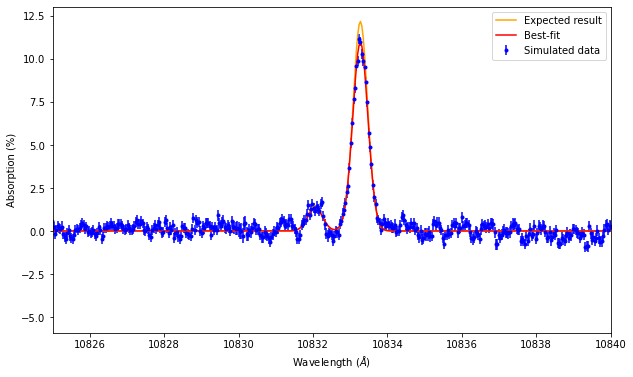

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06349633e+04 -1.04622276e+15 -3.69506920e-04]


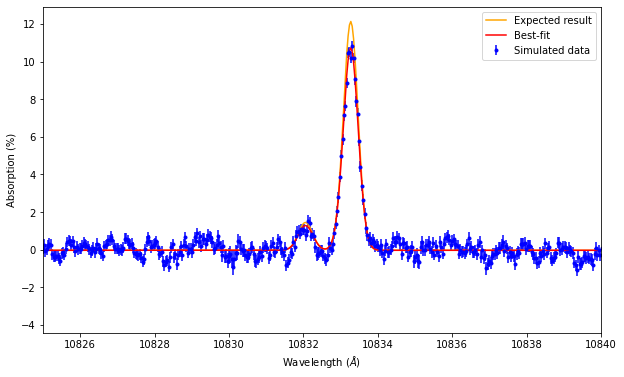

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02975643e+04 -1.05146931e+15  5.98399475e-04]


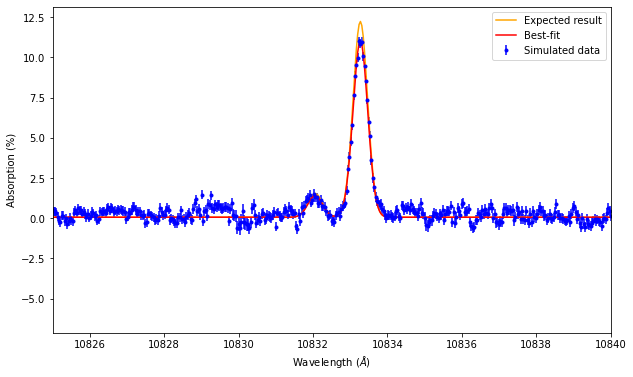

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14727528e+04 -1.07533536e+15  2.85163081e-04]


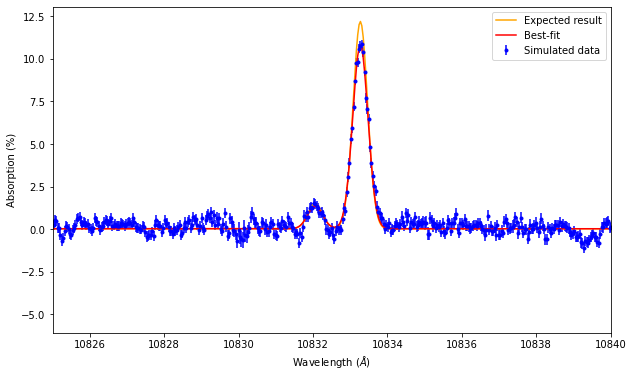

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07192160e+04 -1.06954849e+15 -7.14133027e-05]


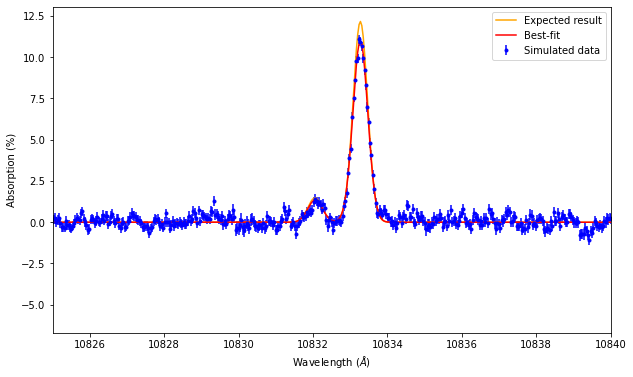

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05324059e+04 -1.06286260e+15  2.95643423e-04]


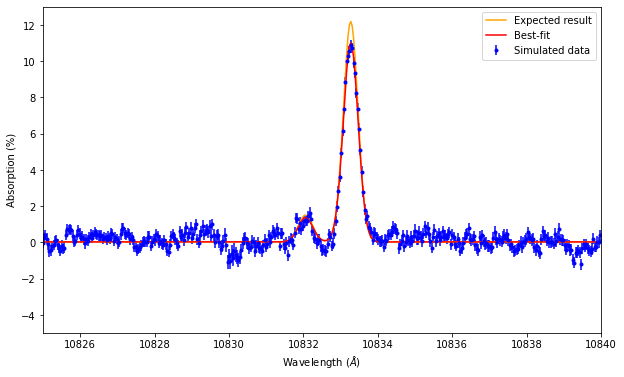

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.73101453e+03 -1.04027407e+15  4.28023335e-04]


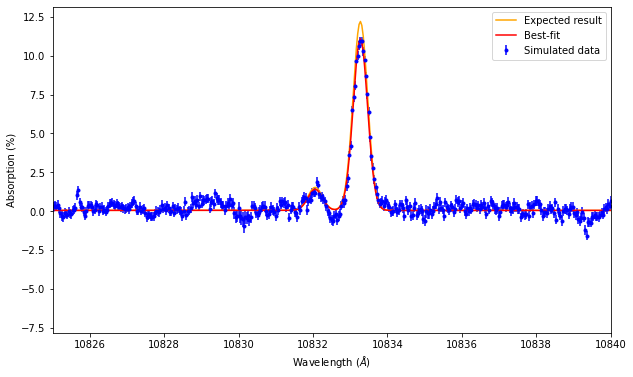

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11552471e+04 -1.07056265e+15  2.20248712e-04]


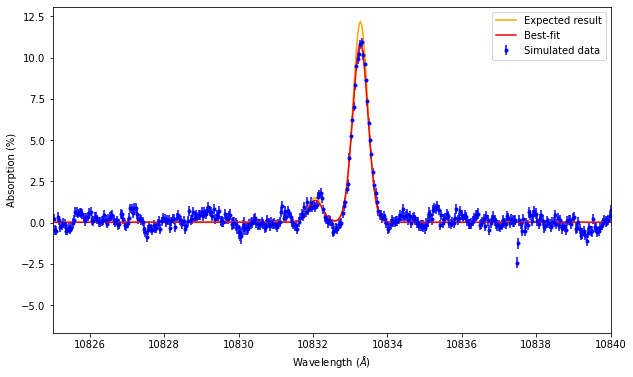

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01410677e+04 -1.05217286e+15  1.96291820e-04]


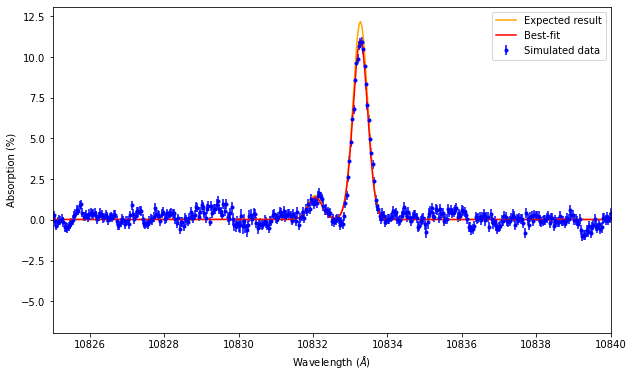

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06625612e+04 -1.06907407e+15  2.01653698e-04]


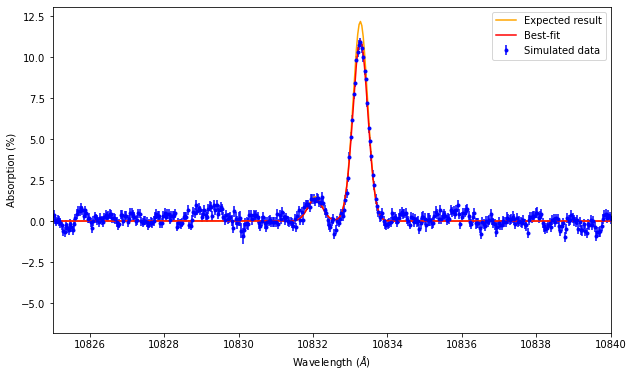

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10683262e+04 -1.06848208e+15  1.72179265e-04]


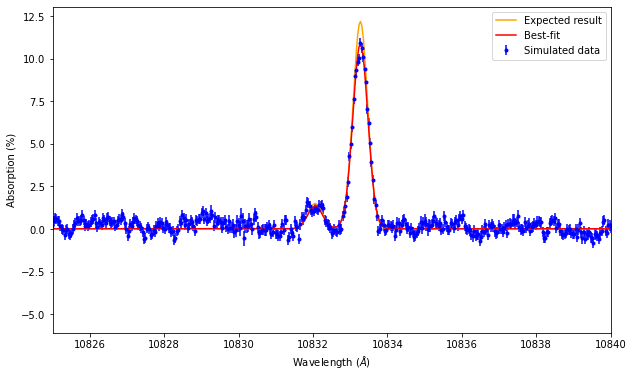

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03427475e+04 -1.04689192e+15  6.14989981e-05]


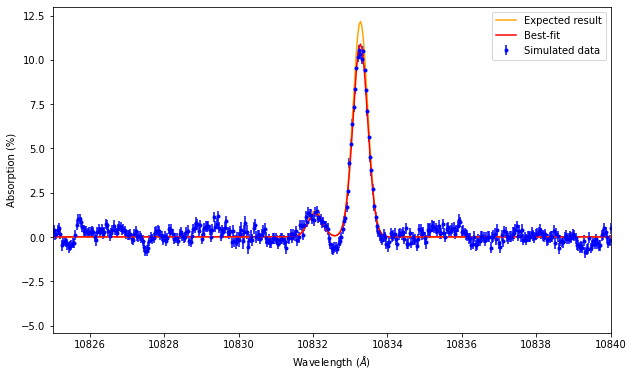

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.67140752e+03 -1.03994791e+15  2.25660034e-04]


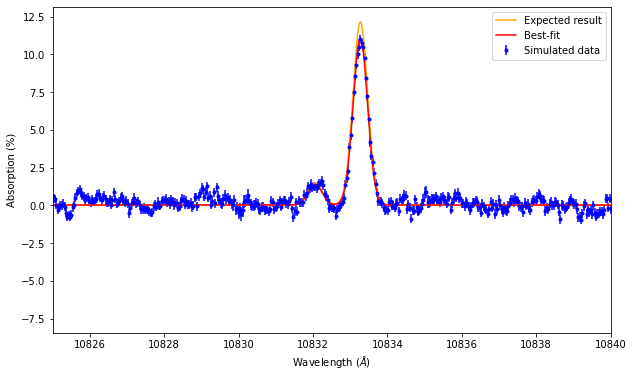

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.36371959e+03 -1.03160657e+15 -1.40997851e-04]


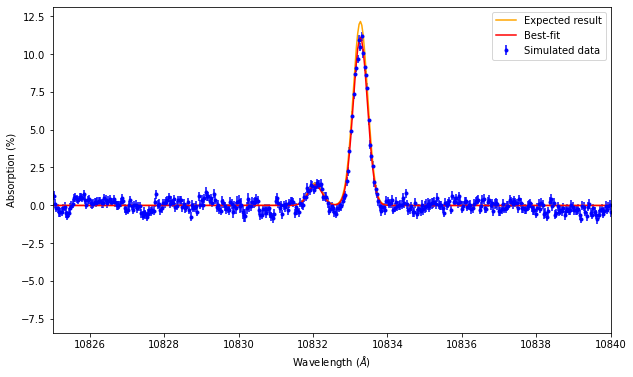

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.74032089e+03 -1.03989438e+15 -1.29851929e-04]


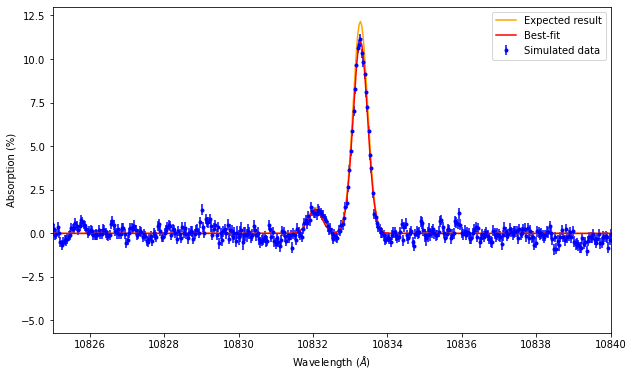

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.45009553e+03 -1.03925833e+15 -3.12120513e-04]


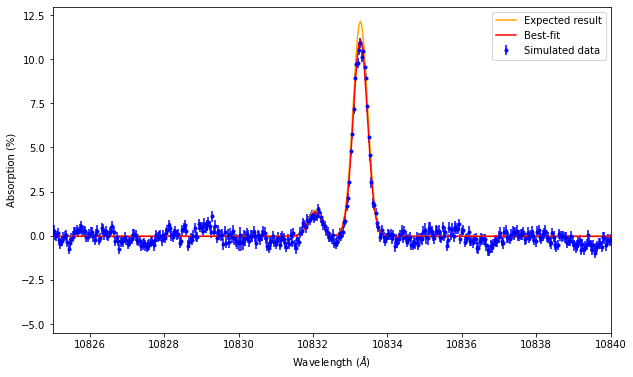

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.55106936e+03 -1.03183752e+15  6.17402863e-05]


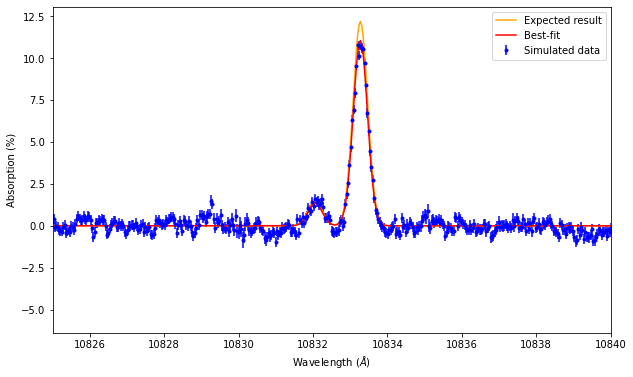

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00523502e+04 -1.04673211e+15 -2.26132975e-04]


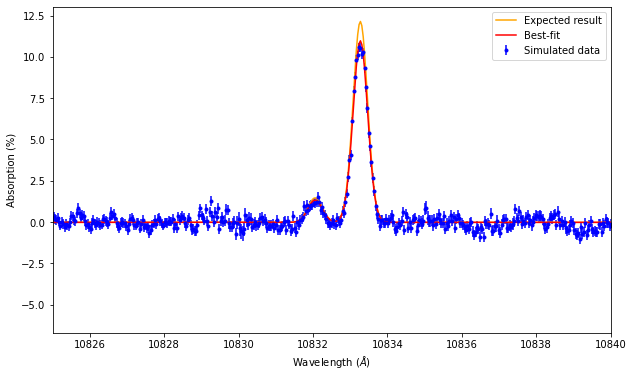

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03417048e+04 -1.05114449e+15 -7.09507157e-05]


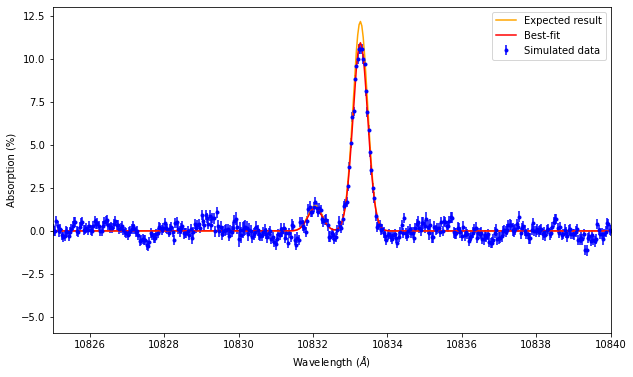

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10646269e+04 -1.08791178e+15 -2.52163140e-04]


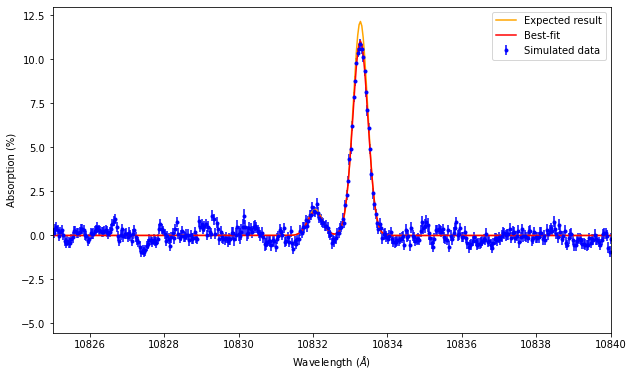

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11395225e+04 -1.07959079e+15 -2.50665365e-04]


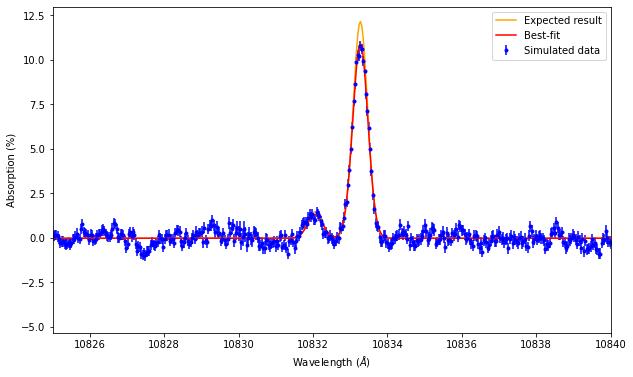

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.15438164e+04 -1.08879378e+15 -1.97353745e-04]


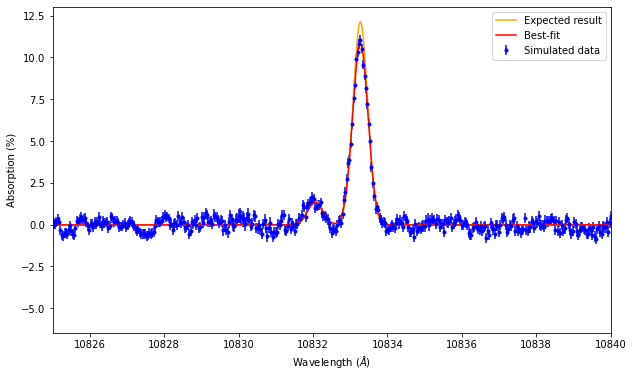

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06969781e+04 -1.06550125e+15 -1.04088104e-04]


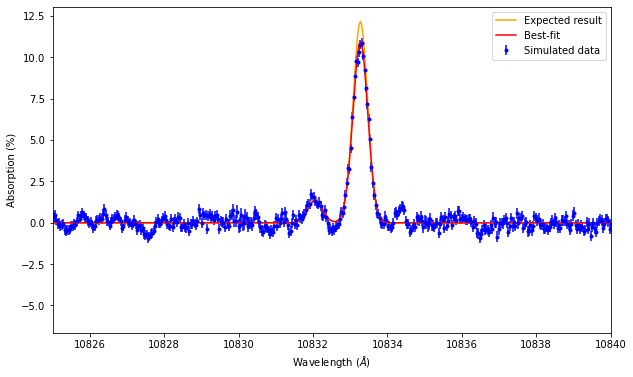

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11472095e+04 -1.07547670e+15 -1.16288675e-04]


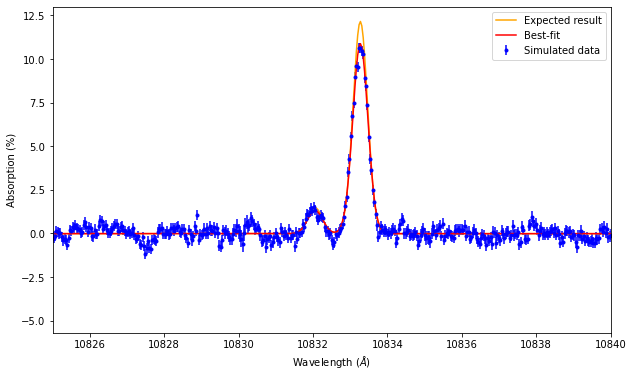

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.11612183e+04 -1.08398921e+15  9.95145867e-05]


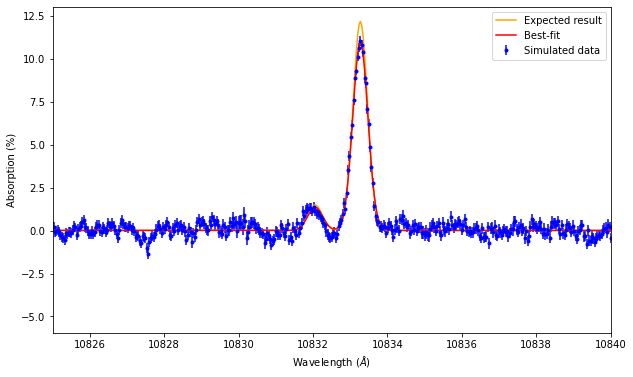

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12485096e+04 -1.08327354e+15  1.36286349e-04]


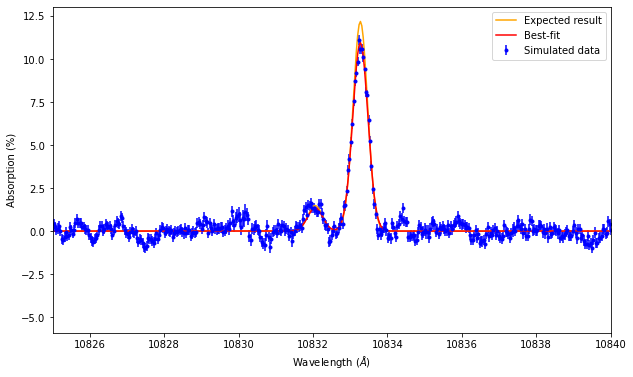

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10931415e+04 -1.05431080e+15  1.85796733e-04]


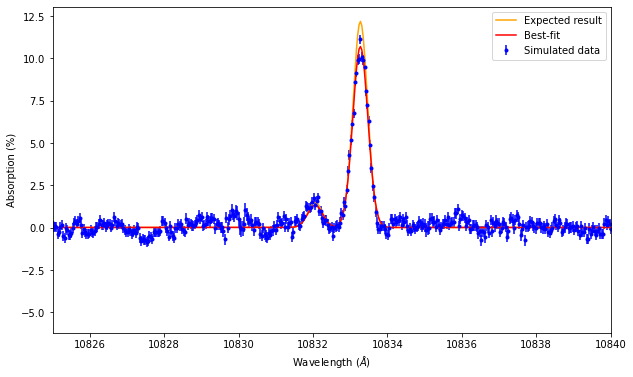

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04835230e+04 -1.05305958e+15  1.19698166e-04]


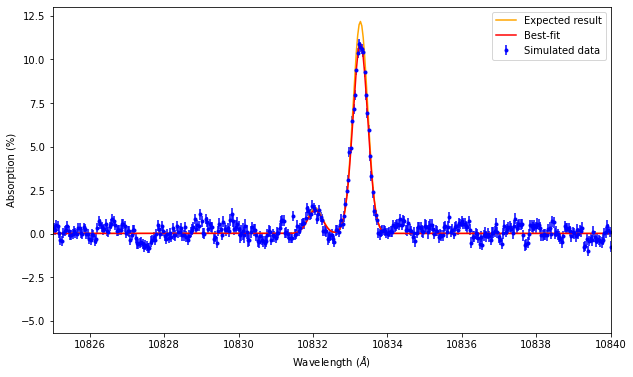

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04670039e+04 -1.04232323e+15  7.79262811e-05]


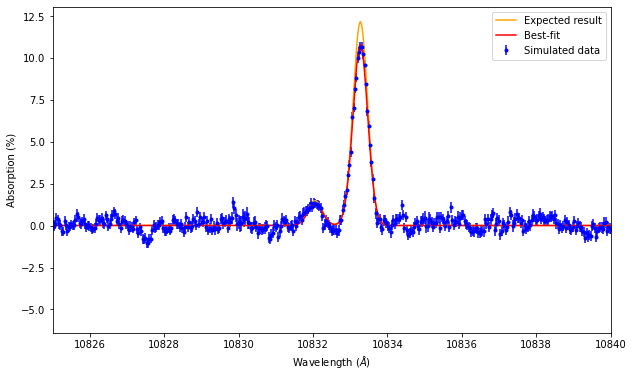

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06589134e+04 -1.03762596e+15  3.53816580e-04]


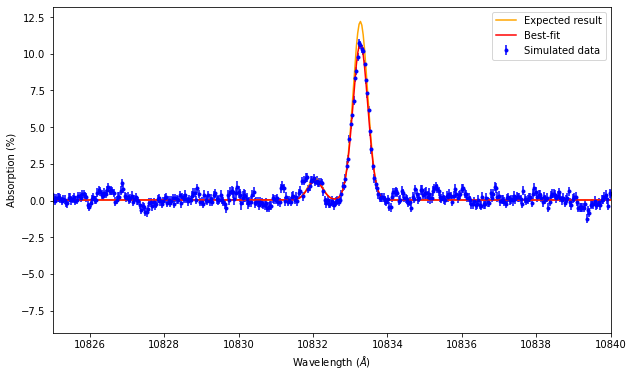

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07211191e+04 -1.05185427e+15  4.02262540e-05]


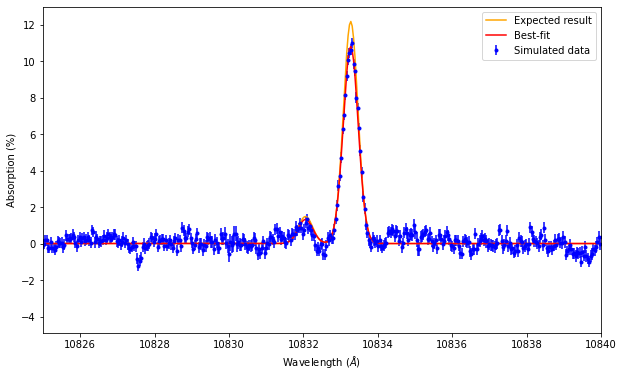

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10310910e+04 -1.05657606e+15 -2.94182446e-05]


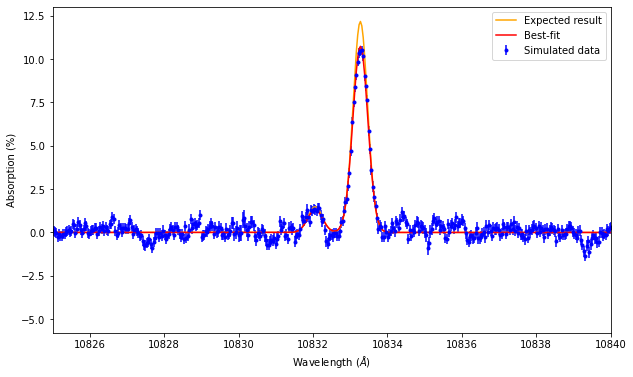

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04139831e+04 -1.03927677e+15  9.09097444e-06]


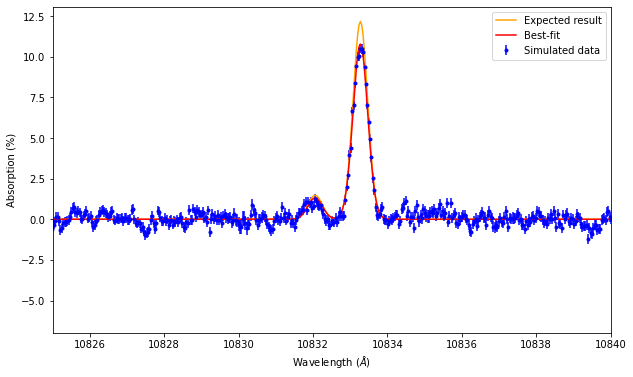

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05808282e+04 -1.05263627e+15  1.98381743e-04]


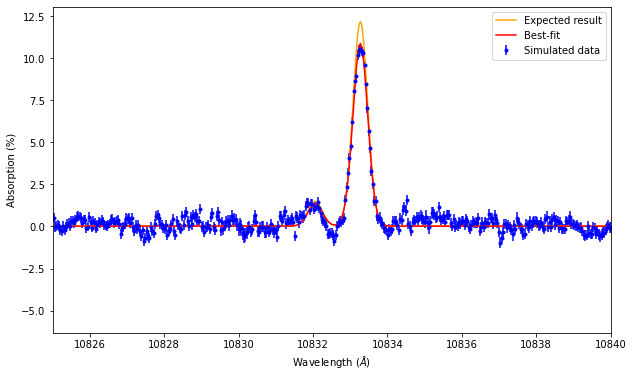

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.98549756e+03 -1.05586428e+15  1.15587449e-04]


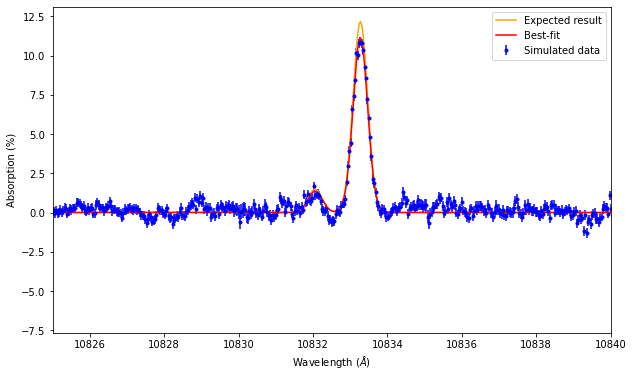

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00100039e+04 -1.04598293e+15 -1.46423769e-04]


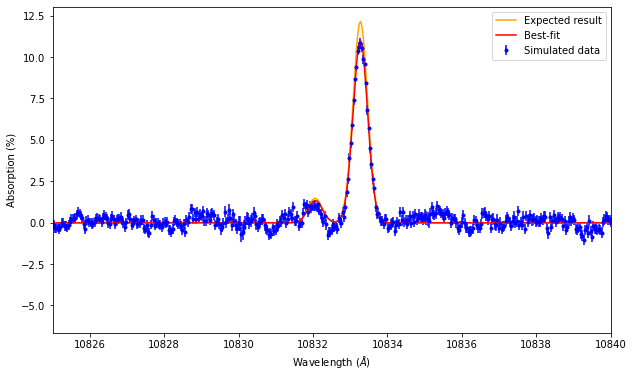

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08653227e+04 -1.05988251e+15  4.96436204e-05]


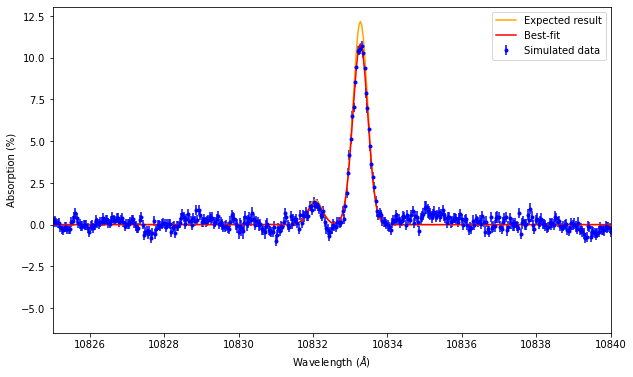

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08212162e+04 -1.07267292e+15  1.06555639e-05]


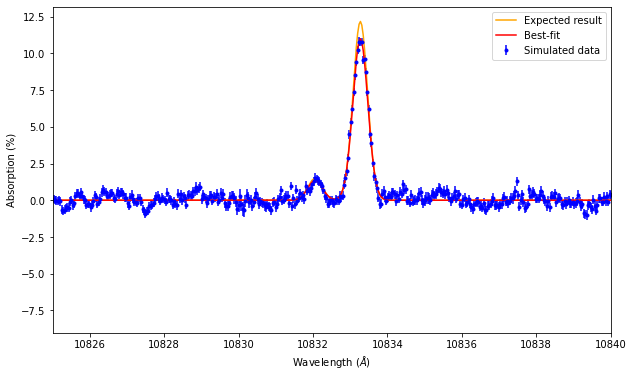

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.95157383e+03 -1.01705868e+15  9.09730869e-05]


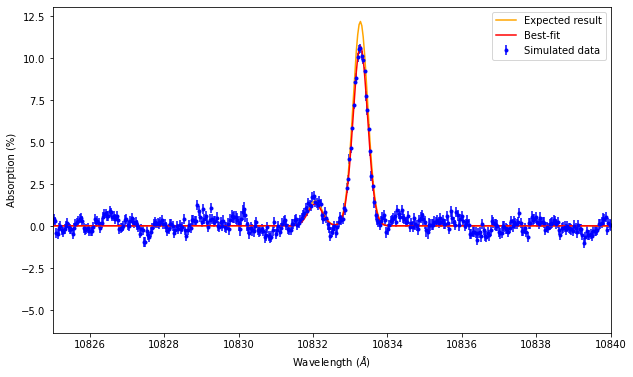

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.86225365e+03 -1.03763158e+15  3.82972199e-04]


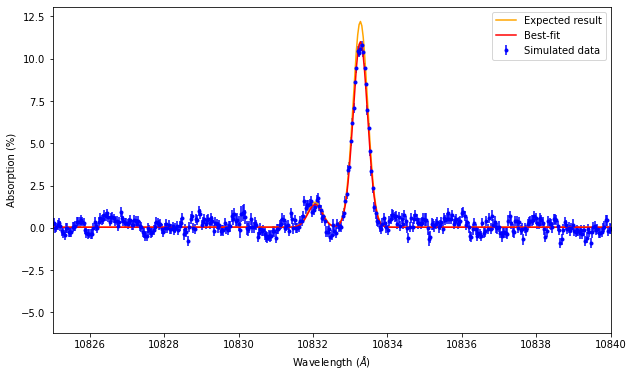

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01081381e+04 -1.04812266e+15  2.70121244e-04]


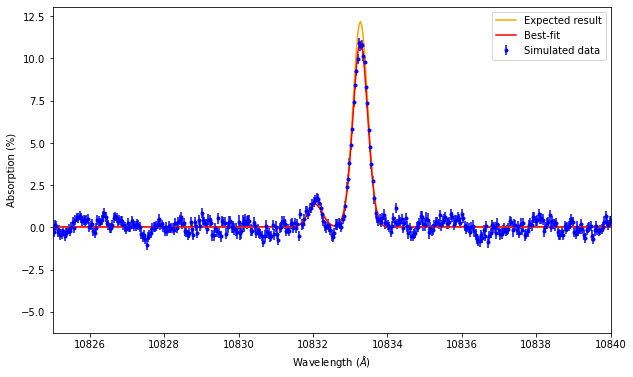

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00955125e+04 -1.02809885e+15 -3.15072004e-05]


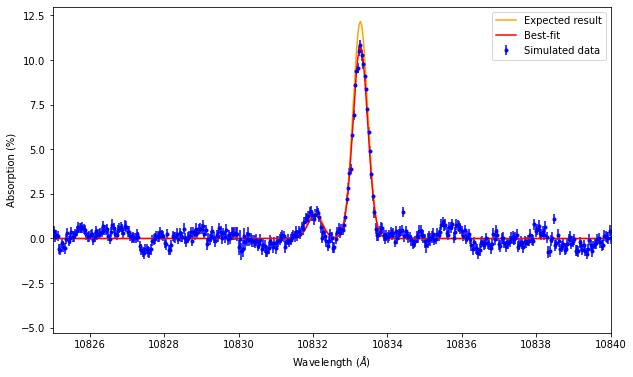

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.34511885e+03 -1.04361734e+15 -6.40019573e-05]


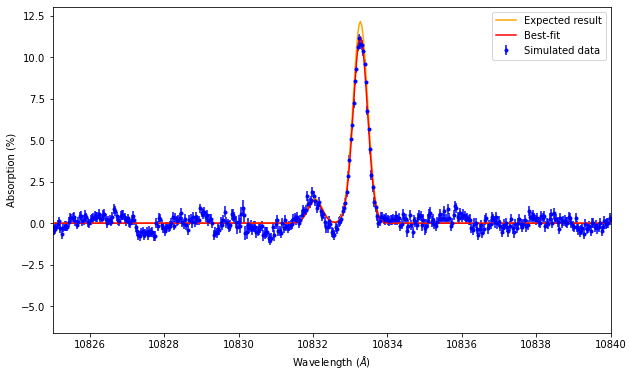

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04855665e+04 -1.04941106e+15  1.37853761e-04]


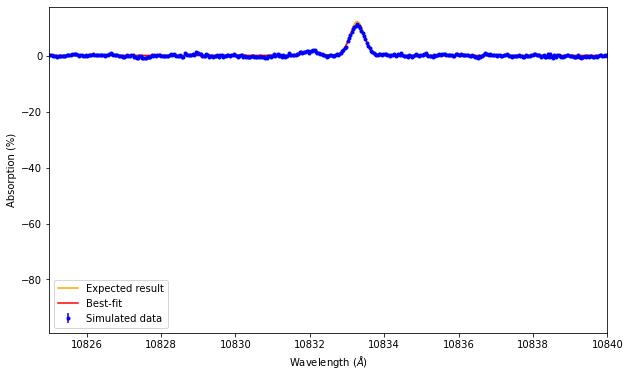

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.02412321e+04 -1.05285092e+15 -3.93547102e-06]


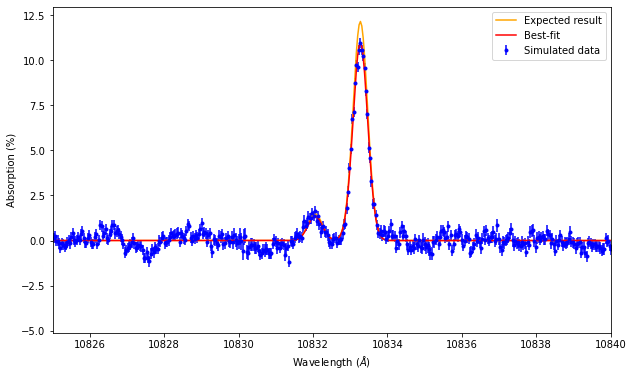

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.00024295e+04 -1.05769974e+15 -2.18372747e-04]


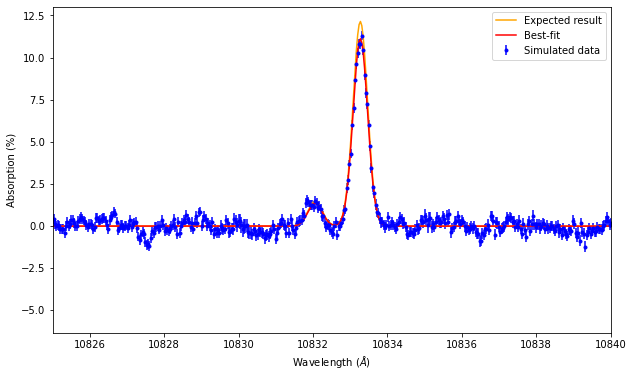

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09043039e+04 -1.06988936e+15 -6.15179487e-05]


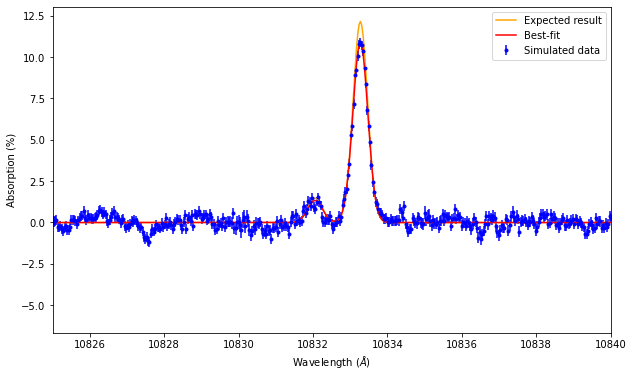

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04501694e+04 -1.06790652e+15  3.09972900e-05]


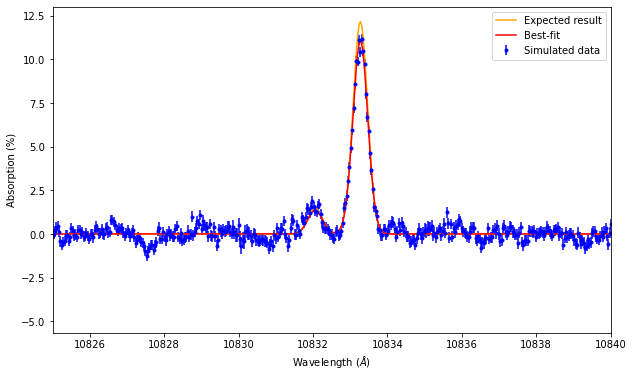

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05499536e+04 -1.07130522e+15  2.41307080e-05]


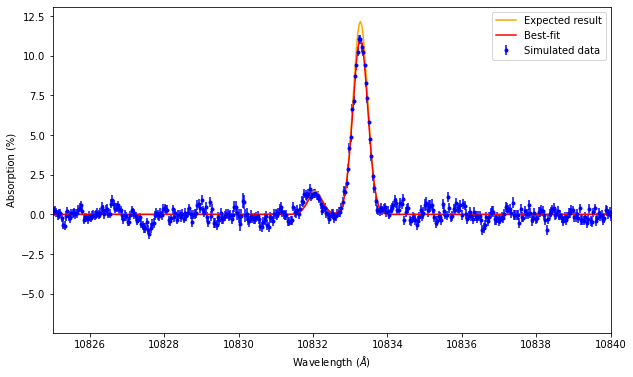

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01076970e+04 -1.04380631e+15 -1.15685054e-04]


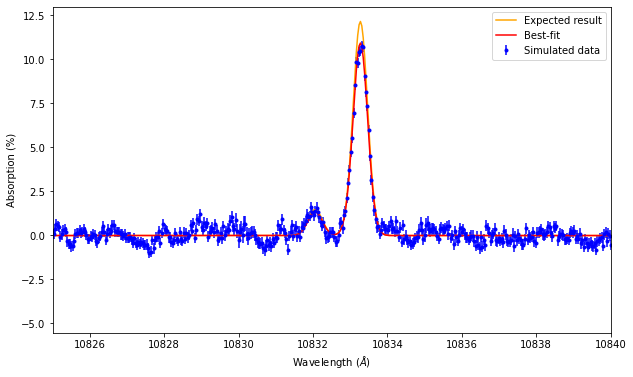

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.10910114e+04 -1.06154253e+15 -7.51360036e-05]


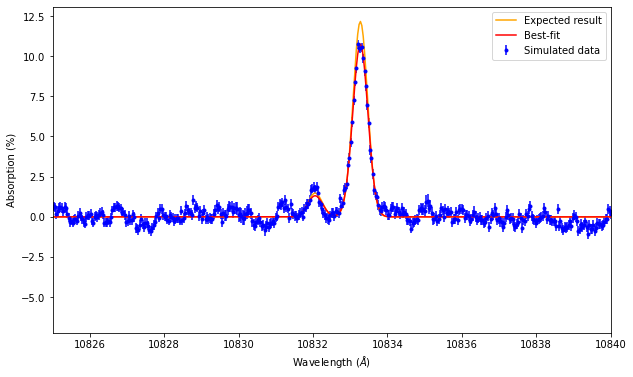

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.17648140e+04 -1.07795847e+15  2.61828192e-04]


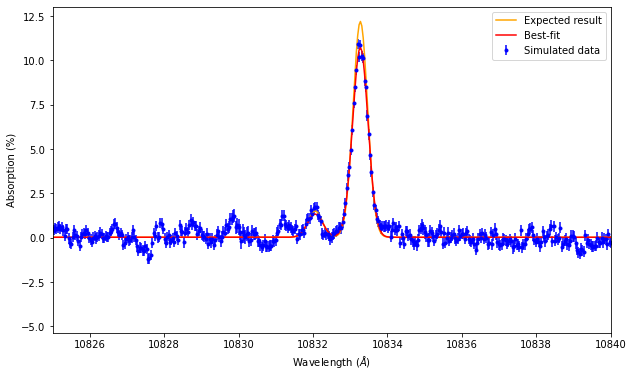

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09866178e+04 -1.05264130e+15  3.80431027e-04]


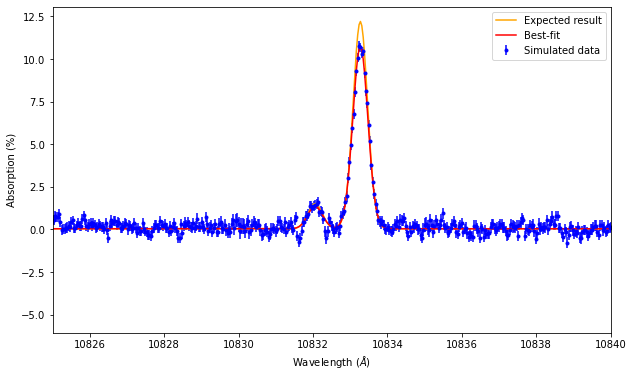

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.16611450e+04 -1.04414469e+15  3.32003777e-05]


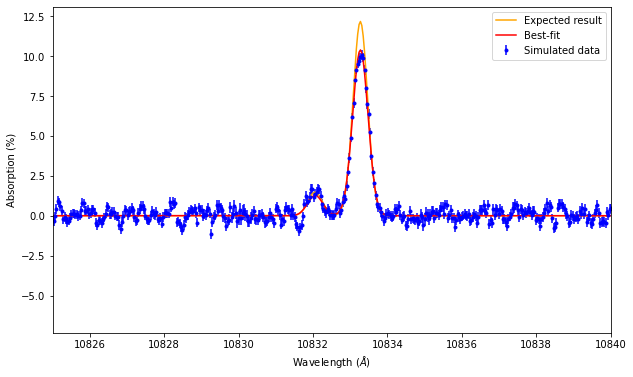

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.07233412e+04 -1.03909016e+15 -5.42470487e-05]


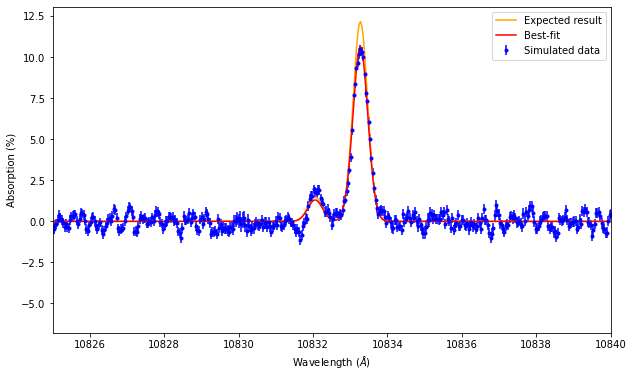

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 9.39226065e+03 -1.00806080e+15 -1.11910568e-04]


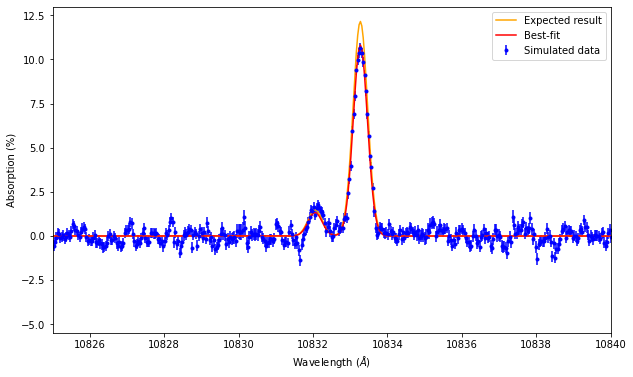

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.01498690e+04 -1.03800984e+15 -1.56937181e-04]


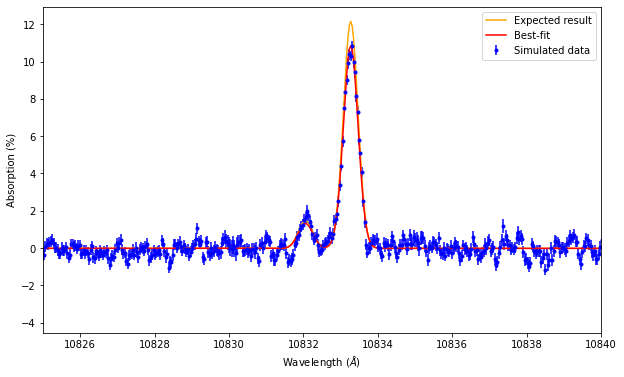

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06961374e+04 -1.06754983e+15  2.12363142e-04]


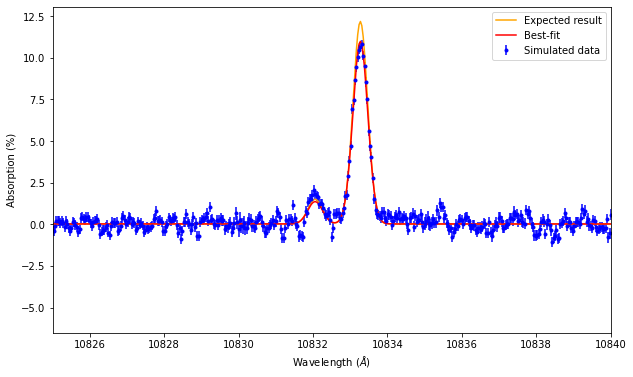

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03843764e+04 -1.06237740e+15 -2.48891825e-04]


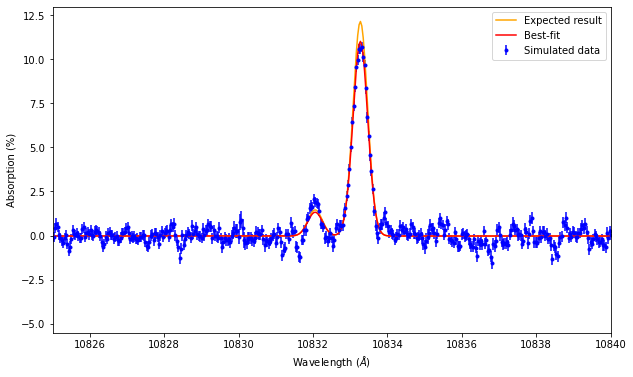

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.13537874e+04 -1.09050458e+15 -5.98416895e-05]


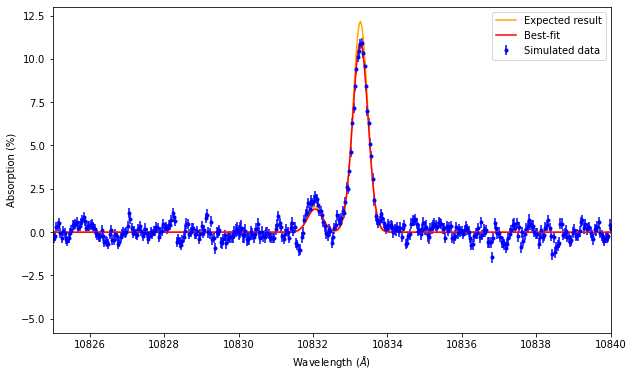

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.19411568e+04 -1.09529774e+15 -4.01125251e-05]


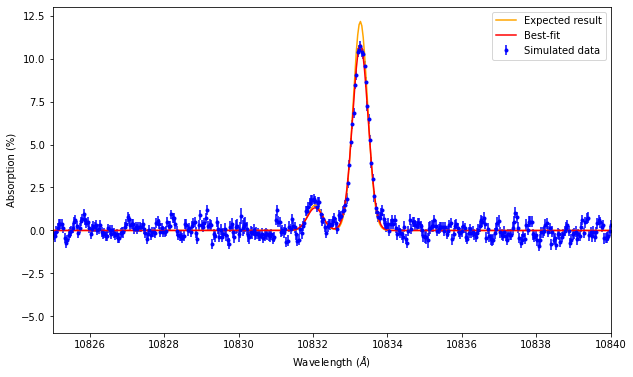

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.06926985e+04 -1.03704274e+15  5.31882134e-05]


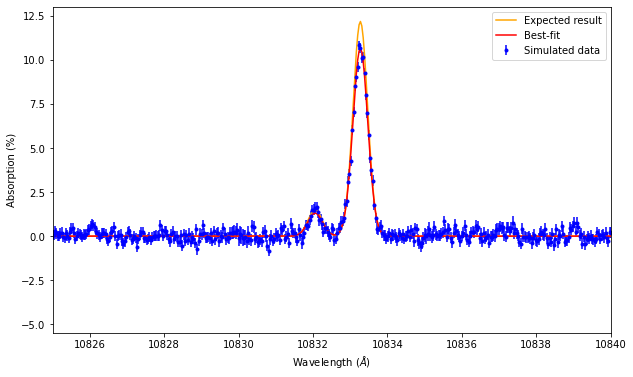

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.09693214e+04 -1.04743228e+15  2.17328939e-04]


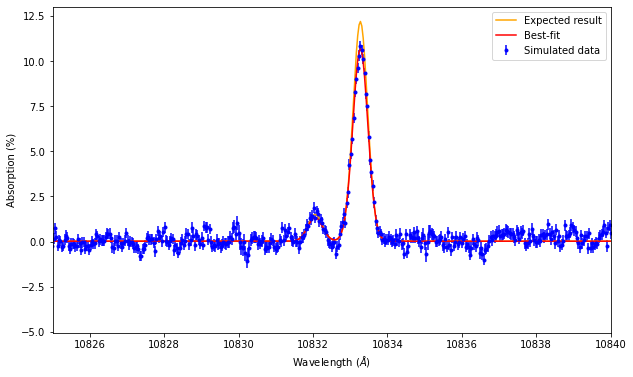

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08336681e+04 -1.06394648e+15  1.23547020e-04]


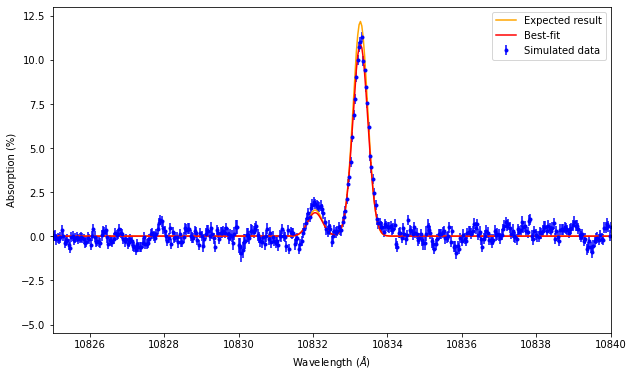

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04043075e+04 -1.04473629e+15  6.88441752e-06]


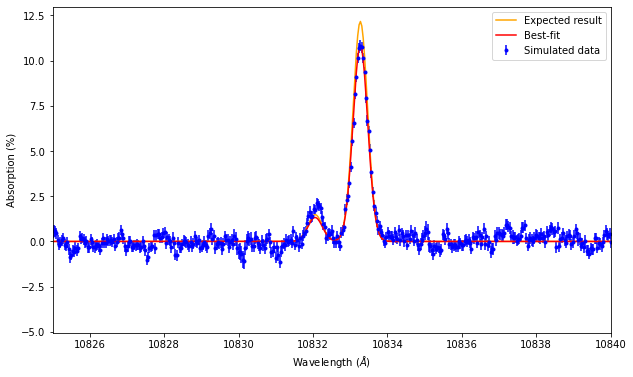

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.12060623e+04 -1.09056716e+15  2.19703697e-04]


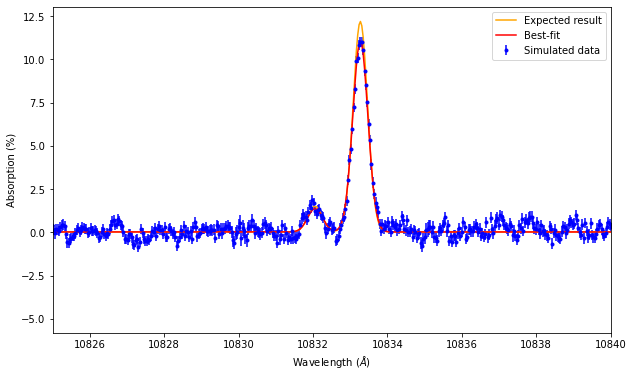

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.22392454e+04 -1.11123909e+15  9.90094257e-05]


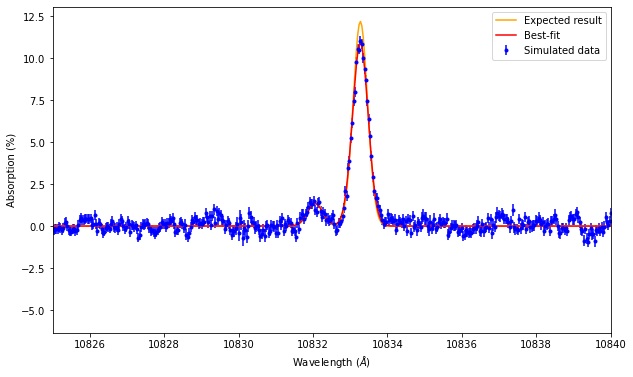

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.20937430e+04 -1.10183543e+15  3.74211279e-05]


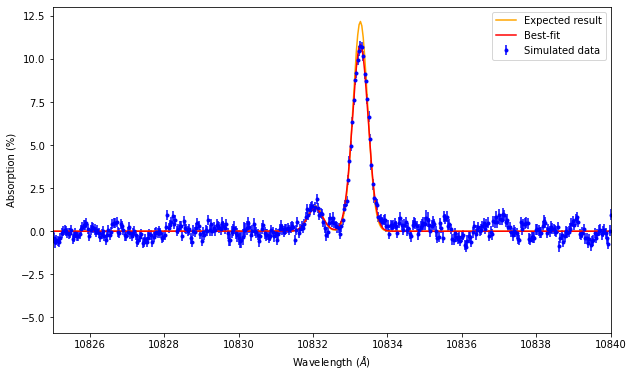

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.14575555e+04 -1.08156150e+15  2.81966364e-04]


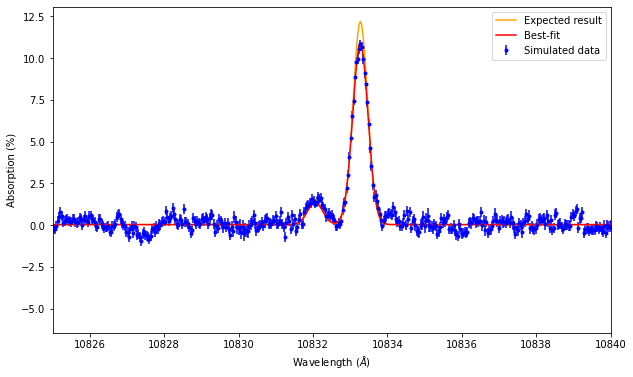

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08092273e+04 -1.05027996e+15  5.18194184e-05]


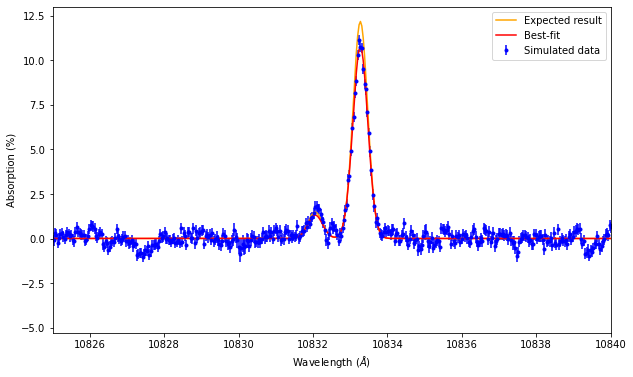

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.05831798e+04 -1.04676221e+15 -1.19475232e-04]


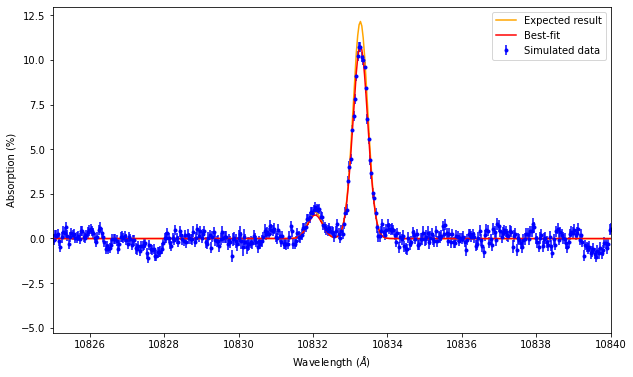

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.08188167e+04 -1.06948454e+15  2.21443492e-04]


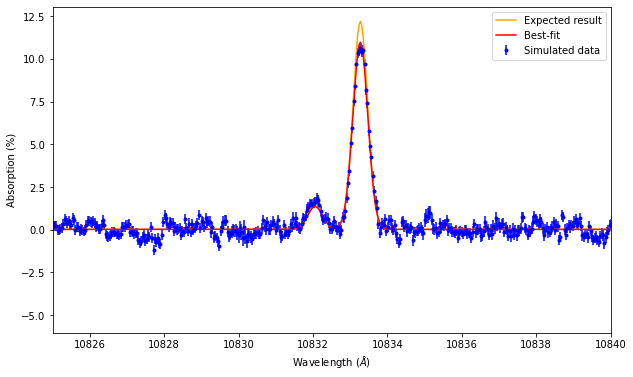

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.03266246e+04 -1.06331706e+15 -2.18598225e-04]


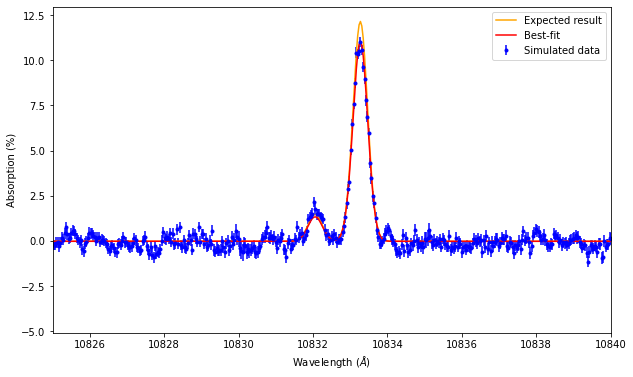

/Users/samsonmercier/Desktop/UNIGE/Winter_Semester_2022-2023/APLII/he_triplet/line_model.py:133: RuntimeWarning: invalid value encountered in sqrt
  vt = np.sqrt(2.*k_boltz * T / m)


[ 1.04894227e+04 -1.07242591e+15  4.53084422e-04]


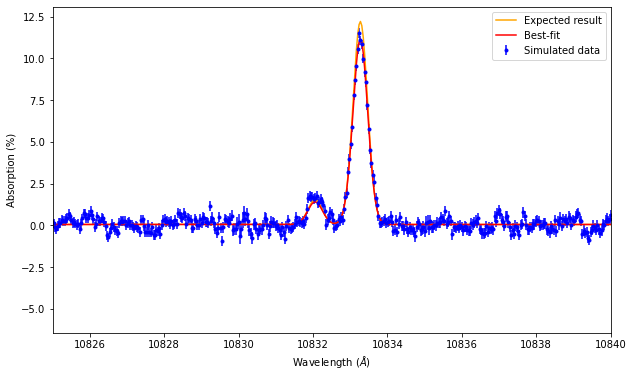

In [58]:
reload(AF)

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    #Re-defining the absorption function
    #We fix the stellar velocity because the Sun's velocity is well known.
    #We fit for the atmospheric He column density and the temperature of the atmosphere.
    def absorption_function_HA(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_HA[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HA)

    def absorption_function_HE(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff_HE[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power_HE)

    #Creating arrays to store the best-fit parameters and the error on them
    param_HA = np.zeros((len(diff_HA), 3))
    err_HA = np.zeros((len(diff_HA), 3))

    param_HE = np.zeros((len(diff_HE), 3))
    err_HE = np.zeros((len(diff_HE), 3))

    #Iterating over the time series to get a value of the retrieved parameters for each spectrum
    for i in range(len(diff_HA)):
        #Guess on the initial parameters
        guess = [16000, 1e14, np.median(diff_HA[i])]

        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function_HA, ref_wave, diff_HA[i], sigma = diff_HA_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param_HA[i] = params
        err_HA[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function_HA(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff_HA[i]-1+params[2]), yerr=100*diff_HA_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function_HA(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()
        
    for i in range(len(diff_HE)):
        #Guess on the initial parameters
        guess = [16000, 1e14, np.median(diff_HE[i])-1]
        print(np.median(diff_HE[i])-1)
        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function_HE, ref_wave, diff_HE[i], sigma=diff_HE_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param_HE[i] = params
        err_HE[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function_HE(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff_HE[i]-1+params[2]), yerr = 100*diff_HE_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function_HE(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'k', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()

#If there is one mode of observation
else:
    #Re-defining the absorption function
    #We fix the stellar velocity because the Sun's velocity is well known.
    #We fit for the atmospheric He column density and the temperature of the atmosphere.
    def absorption_function(x, temp, density, offset):
        return offset+spec_mod.spectrum_he(x, np.ones(diff[0].shape), temp, density, vsini, 'VACUUM', R_pow = R_power)

    #Creating arrays to store the best-fit parameters and the error on them
    param = np.zeros((len(diff), 3))
    err = np.zeros((len(diff), 3))
    
   #Iterating over the time series to get a value of the retrieved parameters for each spectrum
    for i in range(len(diff)):

        guess = [16000, 1e14, np.median(diff[i])]
        
        #Chi-squared minimization routine
        params, cov = curve_fit(absorption_function, ref_wave, diff[i], sigma=diff_err[i], p0=guess)

        #Storing the best-fit parameters and errors
        param[i] = params
        err[i] = np.sqrt(np.diag(cov))

        #Plotting the in-transit planetary spectra and their corresponding model
        print(params)
        plt.figure(figsize=[10, 6])
        model = absorption_function(ref_wave, params[0], params[1], params[2])
        plt.errorbar(ref_wave, 100*(diff[i]-1+params[2]), 100*diff_err[i], fmt='b.', label='Simulated data')
        plt.plot(ref_wave, 100*(absorption_function(ref_wave, temperature, -density, params[2])-1), color='orange', label='Expected result')
        plt.plot(ref_wave, 100*(model-1), 'r', label='Best-fit')
        plt.xlim([10825, 10840])
        plt.xlabel('Wavelength ($\AA$)')
        plt.ylabel('Absorption (%)')
        plt.legend()
        plt.show()


#For fitting purposes, we needed to have negative densities, so we revert to positive values.
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):
    param_HA[:, 1] = -param_HA[:, 1]
    param_HE[:, 1] = -param_HE[:, 1]
#For fitting purposes, we needed to have negative densities, so we revert to positive values.
else:    
    param[:, 1] = -param[:, 1]



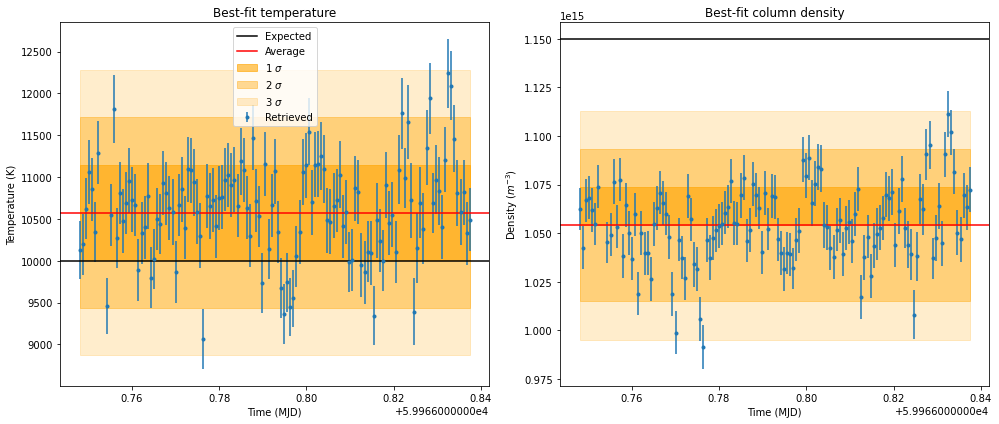

In [64]:
reload(AF)

#Defining a variable to save or not the results.
save = False

#Distinguish two cases depending on the number of modes of observation
#If there are two modes of observation
if np.sum(mode=='A') != len(mode) and np.sum(mode=='E')!= len(mode):

    fig , ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[18, 12])
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T_HA = np.average(param_HA[:, 0], weights=1/err_HA[:, 0]**2)
    weighted_std_T_HA = np.sqrt(np.average((param_HA[:, 0] - weighted_avg_T_HA)**2, weights=1/err_HA[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax1.errorbar(date_in_transit_HA, param_HA[:, 0], yerr = err_HA[:, 0], fmt='.', label='Retrieved')
    ax1.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Best-fit temperature for HA')
    ax1.axhline(temperature, color='k', label='Expected')
    ax1.axhline(weighted_avg_T_HA, color='r', label='Average')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-weighted_std_T_HA, y2 = weighted_avg_T_HA+weighted_std_T_HA, alpha=0.6, color='orange', label='1 $\sigma$')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-2*weighted_std_T_HA, y2 = weighted_avg_T_HA+2*weighted_std_T_HA, alpha=0.4, color='orange', label='2 $\sigma$')
    ax1.fill_between(date_in_transit_HA, y1 = weighted_avg_T_HA-3*weighted_std_T_HA, y2 = weighted_avg_T_HA+3*weighted_std_T_HA, alpha=0.2, color='orange', label='3 $\sigma$')
    ax1.legend(framealpha=0.8)
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T_HE = np.average(param_HE[:, 0], weights=1/err_HE[:, 0]**2)
    weighted_std_T_HE = np.sqrt(np.average((param_HE[:, 0] - weighted_avg_T_HE)**2, weights=1/err_HE[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax2.errorbar(date_in_transit_HE, param_HE[:, 0], yerr = err_HE[:, 0], fmt='.', label='Retrieved')
    ax2.set_xlabel('Time (MJD)')
    ax2.set_ylabel('Temperature (K)')
    ax2.set_title('Best-fit temperature for HE')
    ax2.axhline(temperature, color='k', label='Expected')
    ax2.axhline(weighted_avg_T_HE, color='r', label='Average')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-weighted_std_T_HE, y2 = weighted_avg_T_HE+weighted_std_T_HE, alpha=0.6, color='orange', label='1 $\sigma$')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-2*weighted_std_T_HE, y2 = weighted_avg_T_HE+2*weighted_std_T_HE, alpha=0.4, color='orange', label='2 $\sigma$')
    ax2.fill_between(date_in_transit_HE, y1 = weighted_avg_T_HE-3*weighted_std_T_HE, y2 = weighted_avg_T_HE+3*weighted_std_T_HE, alpha=0.2, color='orange', label='3 $\sigma$')
    
    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho_HA = np.average(param_HA[:, 1], weights=1/err_HA[:, 1]**2)
    weighted_std_rho_HA = np.sqrt(np.average((param_HA[:, 1] - weighted_avg_rho_HA)**2, weights=1/err_HA[:, 1]**2))
    
    #Plotting the retrieved densities.
    ax3.errorbar(date_in_transit_HA, param_HA[:, 1], yerr = err_HA[:, 1], fmt='.', label='Retrieved')
    ax3.set_xlabel('Time (MJD)')
    ax3.set_ylabel('Density ($m^{-3}$)')
    ax3.set_title('Best-fit column density for HA')
    ax3.axhline(density, color='k', label='Expected')
    ax3.axhline(weighted_avg_rho_HA, color='r', label='Average')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-weighted_std_rho_HA, y2 = weighted_avg_rho_HA+weighted_std_rho_HA, alpha=0.6, color='orange', label='1 $\sigma$')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-2*weighted_std_rho_HA, y2 = weighted_avg_rho_HA+2*weighted_std_rho_HA, alpha=0.4, color='orange', label='2 $\sigma$')
    ax3.fill_between(date_in_transit_HA, y1 = weighted_avg_rho_HA-3*weighted_std_rho_HA, y2 = weighted_avg_rho_HA+3*weighted_std_rho_HA, alpha=0.2, color='orange', label='3 $\sigma$')

    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho_HE = np.average(param_HE[:, 1], weights=1/err_HE[:, 1]**2)
    weighted_std_rho_HE = np.sqrt(np.average((param_HE[:, 1] - weighted_avg_rho_HE)**2, weights=1/err_HE[:, 1]**2))
    
    #Plotting the retrieved densities.
    ax4.errorbar(date_in_transit_HE, param_HE[:, 1], yerr = err_HE[:, 1], fmt='.', label='Retrieved ')
    ax4.set_xlabel('Time (MJD)')
    ax4.set_ylabel('Density ($m^{-3}$)')
    ax4.set_title('Best-fit column density for HE')
    ax4.axhline(density, color='k', label='Expected')
    ax4.axhline(weighted_avg_rho_HE, color='r', label='Average')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-weighted_std_rho_HE, y2 = weighted_avg_rho_HE+weighted_std_rho_HE, alpha=0.6, color='orange', label='1 $\sigma$')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-2*weighted_std_rho_HE, y2 = weighted_avg_rho_HE+2*weighted_std_rho_HE, alpha=0.4, color='orange', label='2 $\sigma$')
    ax4.fill_between(date_in_transit_HE, y1 = weighted_avg_rho_HE-3*weighted_std_rho_HE, y2 = weighted_avg_rho_HE+3*weighted_std_rho_HE, alpha=0.2, color='orange', label='3 $\sigma$')

    ax1.sharey(ax2)
    ax3.sharey(ax4)

    fig.tight_layout()
    if save:
        plt.savefig(location+'/Plot_Results/Retrieved_Params.pdf')

#If there is one mode of observation
else:
    
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=[14, 6])
    
    #Defining the average and standard deviation of the retrieved temperatures.
    weighted_avg_T = np.average(param[:, 0], weights=1/err[:, 0]**2)
    weighted_std_T = np.sqrt(np.average((param[:, 0] - weighted_avg_T)**2, weights=1/err[:, 0]**2))
    
    #Plotting the retrieved temperatures.
    ax1.errorbar(date_in_transit, param[:, 0], yerr = err[:, 0], fmt='.', label='Retrieved')
    ax1.set_xlabel('Time (MJD)')
    ax1.set_ylabel('Temperature (K)')
    ax1.set_title('Best-fit temperature')
    ax1.axhline(temperature, color='k', label='Expected')
    ax1.axhline(weighted_avg_T, color='r', label='Average')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-weighted_std_T, y2 = weighted_avg_T+weighted_std_T, alpha=0.6, color='orange', label='1 $\sigma$')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-2*weighted_std_T, y2 = weighted_avg_T+2*weighted_std_T, alpha=0.4, color='orange', label='2 $\sigma$')
    ax1.fill_between(date_in_transit, y1 = weighted_avg_T-3*weighted_std_T, y2 = weighted_avg_T+3*weighted_std_T, alpha=0.2, color='orange', label='3 $\sigma$')
    ax1.legend()

    #Defining the average and standard deviation of the retrieved densities.
    weighted_avg_rho = np.average(param[:, 1], weights=1/err[:, 1]**2)
    weighted_std_rho = np.sqrt(np.average((param[:, 1] - weighted_avg_rho)**2, weights=1/err[:, 1]**2))
        
    #Plotting the retrieved densities.
    ax2.errorbar(date_in_transit, param[:, 1], yerr = err[:, 1], fmt='.', label='Retrieved')
    ax2.set_xlabel('Time (MJD)')
    ax2.set_ylabel('Density ($m^{-3}$)')
    ax2.set_title('Best-fit column density')
    ax2.axhline(density, color='k', label='Expected')
    ax2.axhline(weighted_avg_rho, color='r', label='Average')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-weighted_std_T, y2 = weighted_avg_rho+weighted_std_rho, alpha=0.6, color='orange', label='1 $\sigma$')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-2*weighted_std_rho, y2 = weighted_avg_rho+2*weighted_std_rho, alpha=0.4, color='orange', label='2 $\sigma$')
    ax2.fill_between(date_in_transit, y1 = weighted_avg_rho-3*weighted_std_rho, y2 = weighted_avg_rho+3*weighted_std_rho, alpha=0.2, color='orange', label='3 $\sigma$')

    fig.tight_layout()
    if save:
        plt.savefig(location+'/Plot_Results/Retrieved_Params.pdf')
   

In [62]:
print(np.mean(param[:,1]))

1054496057521798.0
